# Task 3 - Cluster Analysis - Hard Clustering

Getting a deep understanding of how customers use your mobility service is crucial. As an example, for marketing purposes, or managerial decisions. One widely adopted approach to understand customers’ behavior is to find prevalent usage/trip clusters. 

**Tasks:** Based on the taxi trip patterns, can you identify clusters of trip types and/or customer types? How would you label these clusters? 

**Methods:** Identify clusters with soft-clustering and visualize your results. Compare your results to a hard-clustering method of your choice. You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data. 

Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e., using Spatial Kernel Density Estimation)?

In this section we do cluster analysis on taxi data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).
We try to find pattern in the data, identify them and in addition to that we are interested in labeling these cluster patterns.

We are going to do different cluster analysis:

- customer types based on different features
- location based clustering

In general we do a hard and soft clustering, but in this part we perform the soft clustering. The soft clustering we use is the Gaussian Mixture Model.

Our procedure in this part is structured in the following way. For every different cluster analysis we do the following:

- small preprocessing
- deciding for the number of clusters
- process cluster analysis
- analyze und label the clusters

<hr style="border: 1px solid #8888;">

In [2]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mlp
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
#from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
import math
from sklearn.metrics import mean_squared_error
sns.set_theme()

import sklearn
from sklearn.cluster import KMeans
import folium

In [3]:
# import datasets
dfChicago = pd.read_csv("..\data\datasets\df_chicago.csv.zip")

## Functions defined for cluster analysis

### 1) Scaling function

#### Data scaling function:

In [4]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    dfChicago_clu_X_locations_scaled = scaler.fit_transform(df1)
    dfChicago_clu_X_locations_scaled_df = pd.DataFrame(dfChicago_clu_X_locations_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return dfChicago_clu_X_locations_scaled_df



### 2) k-means++ Cluster Functions:

In [5]:
def get_clusters_and_losses(input_data):
    
    clusters_dfChicago_clu_X = []
    losses_dfChicago_clu_X = []

    for k in range(20):
        model_clu_X = KMeans(n_clusters=k+1,n_init=1)
        model_clu_X.fit(input_data)
        clusters_dfChicago_clu_X.append(k+1)
        losses_dfChicago_clu_X.append(model_clu_X.inertia_)
        
    return clusters_dfChicago_clu_X, losses_dfChicago_clu_X

In [6]:
# method to plot the most valuable number of clusters
def plot_best_fitting_number_of_clusters(input_data, title_info):
    
    fig = plt.figure(figsize=(16,8))

    plt.subplot(1, 2, 1)

    clusters, losses = get_clusters_and_losses(input_data)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.title(f"Number of Clusters {title_info}")

    plt.subplot(1, 2, 2)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,12])
    plt.title(f"Number of Clusters {title_info} - Deeper Look")

    plt.show()

### 3) Plotting functions:

#### Plot cluster information:

In [7]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

#### Plot clusters (scatterplot):

In [8]:
def plot_cluster_scatter(x_column, y_column, df, x_label, y_label):

    colors = {
        2: '#16C835', #green
        1: '#FF7C00',#orange
        4: '#8B2BE2',#violet
        5: '#843C0C',#brown
        0: '#023EFF',#blue
        6: '#FF1493',#rosa
        3:'#FF0000',#red
        7:'#808080'#grey
        # Add more colors for other clusters if needed
    }

    # Create the scatter plot
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

    # Use hue parameter to color the data points based on the 'cluster' column
    sns.scatterplot(x=x_column, y=y_column,data=df,hue='cluster', palette=colors)

    # Add labels and legend
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

    # Move the legend outside and above the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
    # Show the plot
    plt.show()

#### Plot scatter with convex hulls:

In [9]:
# Custom colors for clusters (sorted)
cluster_colors = ['#1f77b4',  # Blue
                  '#ff7f0e',  # Orange
                  '#2ca02c',  # Green
                  '#d62728',  # Red
                  '#9467bd',  # Purple
                  '#8c564b',  # Brown
                  '#e377c2',  # Pink
                  '#7f7f7f',  # Gray
                  '#bcbd22',  # Yellow
                  '#17becf']  # Cyan

# Function to create convex hull polygons for each cluster
def create_convex_hulls(df, x_col, y_col, cluster_col):
    convex_hulls = {}
    for cluster_id, cluster_data in df.groupby(cluster_col):
        points = cluster_data[[x_col, y_col]].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        convex_hulls[cluster_id] = hull_points
    return convex_hulls

# Function to plot the scatter plot with convex hull boundaries and markers
def plot_scatter_with_hulls(df, x_col, y_col, cluster_col, label_col, size_tuple, dp_size, x_label, y_label, plot_title, leg_loc, anchor):
    # Create convex hulls
    convex_hulls = create_convex_hulls(df, x_col, y_col, cluster_col)
    
    # Plot the scatter plot with convex hull boundaries and markers
    plt.figure(figsize=size_tuple)
    for idx, (cluster_id, cluster_data) in enumerate(df.groupby(cluster_col)):
        color = cluster_colors[idx % len(cluster_colors)]  # Use custom colors cyclically
        hull_points = convex_hulls[cluster_id]
        hull_polygon = plt.Polygon(hull_points, alpha=0.2, facecolor=color, edgecolor=color, linewidth=2)
        plt.gca().add_patch(hull_polygon)
        
        inner_points = cluster_data.drop_duplicates([x_col, y_col]).loc[:, [x_col, y_col]]
        plt.scatter(inner_points[x_col], inner_points[y_col], label=cluster_data[label_col].iloc[0], s=dp_size, c=color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(loc=leg_loc, bbox_to_anchor=anchor) 
    plt.grid(True)
    plt.show()


### 4) Functions for calculations:

#### Function for quantiles

In [10]:
def get_quantiles_of_clusters(df, n_cluster, cluster_feature):
    
    # create dataframe to store values of calculated quantiles and return df at the end of the method
    dfChicago_quantiles = pd.DataFrame(df)
    # empty all values inside newly created df to just receive columns
    dfChicago_quantiles = dfChicago_quantiles[0:0]

    for cluster in range(0,n_cluster):
        # get 0.25 quantiles
        dict_quantiles_0_25 = df[df[cluster_feature]==cluster].quantile(q=0.25).to_dict()
        # get 0.75 quantiles
        dict_quantiles_0_75 = df[df[cluster_feature]==cluster].quantile(q=0.75).to_dict()
        # round all entries in dictionaries to one decimal place
        dfQuantiles_0_25 = pd.DataFrame(dict_quantiles_0_25, index=[0]).round(2)
        dfQuantiles_0_75 = pd.DataFrame(dict_quantiles_0_75, index=[0]).round(2)
        # parse all values in newly created dfs to strings
        dfQuantiles_0_25 = dfQuantiles_0_25.astype(str)
        dfQuantiles_0_75 = dfQuantiles_0_75.astype(str)
        # combine both quantile dataframes into one interval dataframe
        dfQuantiles_interval = dfQuantiles_0_25 + " - " + dfQuantiles_0_75
        dfQuantiles_interval['Amount Trips in Cluster'] = df[df[cluster_feature]==cluster][cluster_feature].count().astype(int)
        dfQuantiles_interval['Percentage'] = (df[df[cluster_feature]==cluster][cluster_feature].count()/len(df)).round(4)*100
        # concatenate the quantiles row after row
        dfChicago_quantiles = pd.concat([dfChicago_quantiles, dfQuantiles_interval.loc[dfQuantiles_interval.index.values == 0]])
        
    # lastly styling the output dataframe (dropping unnecessary column, resetting the index, giving "Cluster" as index column name)
    dfChicago_quantiles.drop(columns=[cluster_feature], inplace=True)
    dfChicago_quantiles.reset_index(drop=True, inplace=True)
    dfChicago_quantiles = dfChicago_quantiles.rename_axis('Cluster')    
    
    return dfChicago_quantiles

### 5) Functions for mapping clusters on city map

In [11]:
def get_hex_ids_for_cluster_and_resolution(df, cluster_number, resolution):
    # Filter hex IDs for the specified cluster and resolution
    # Group hex IDs by cluster
    grouped_h3_hex_id = df.groupby('cluster_number')[resolution].apply(set).reset_index()
    
    # Get the list of hex IDs for clusters
    hex_ids_for_clusters = grouped_h3_hex_id[grouped_h3_hex_id['cluster_number'] == cluster_number][resolution].iloc[0]
    
    return hex_ids_for_clusters

In [12]:
from h3 import h3
import folium

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=10, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

<hr style="border: 1px solid #8888;">

## Preprocessing

### Preprocessing for clustering: `start_time_hourly`, `Trip_Miles` and `Trip_Minutes`

To better interpret and analzye the clusters after processing, we convert the `Trip_Seconds` to `Trip_Minutes`. On the one hand we do this simply because minutes are easier to evaluate and on the other hand because the `Trip_Seconds` are always in 60 second-steps anyway.

In [13]:
dfChicago['Trip_Minutes'] = dfChicago['Trip_Seconds']/60
dfChicago.drop(['Trip_Seconds'], axis = 1,inplace =True)

In [14]:
dfChicago = dfChicago[(dfChicago['Trip_Miles'] < dfChicago['Trip_Miles'].quantile(0.95))]
dfChicago = dfChicago[(dfChicago['Trip_Minutes'] < dfChicago['Trip_Minutes'].quantile(0.95))]

In [18]:
# Drop unrealistic fast trips
dfChicago["velocity"] = (dfChicago["Trip_Miles"]/(dfChicago["Trip_Minutes"]/60)).round(2)
dfChicago = dfChicago[(dfChicago['velocity'] < dfChicago['velocity'].quantile(0.95))]
dfChicago = dfChicago[(dfChicago['velocity'] > dfChicago['velocity'].quantile(0.05))]
dfChicago = dfChicago.drop(['velocity'], axis = 1)

In [19]:
dfChicago.reset_index(inplace = True)

In [20]:
dfChicago_cluster = dfChicago[['start_time_hourly','Trip_Minutes',"Trip_Miles"]]
dfChicago_cluster

start_time_hourly  Trip_Minutes  Trip_Miles
0                        0          15.0         2.7
1                        0           4.0         0.4
2                        0           3.0         1.0
3                        0           4.0         0.3
4                        0           8.0         0.8
...                    ...           ...         ...
7247312                 23           3.0         0.5
7247313                 23          19.0         5.1
7247314                 23           9.0         1.4
7247315                 23          12.0         2.0
7247316                 23          11.0         3.5

[7247317 rows x 3 columns]

### Preprocessing for location based clustering: 

#### Creating `distance_to_city_center_pickup` and `distance_to_city_center_dropoff`

In [21]:
#pip install dask

In [22]:
import dask.dataframe as dd
import math

# Coordinates of the city center of chicogo according to https://www.findlatitudeandlongitude.com/l/Chicago+City+centre/5712575/
chicago_city_center = (41.879519, -87.633026)

# Haversine function using Dask's map_partitions for distances in miles
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth radius in miles
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [23]:
ddfChicago = dd.from_pandas(pd.DataFrame(dfChicago), npartitions=8)  # Adjust npartitions as needed

ddfChicago['distance_to_city_center_pickup'] = ddfChicago.map_partitions(
        lambda df: haversine(df['Pickup_Centroid_Latitude'], df['Pickup_Centroid_Longitude'], chicago_city_center[0], chicago_city_center[1]),
        meta=('distance_to_city_center', 'f8')
        )

# Compute the Dask DataFrame to get the final result
dfChicago = ddfChicago.compute()
dfChicago

index                                   Trip_ID  \
0              0  27ad87f629bf14fa3cb894daad514cdad4736f9c   
1              1  9a9d9902dfa267b88400a22a2c9f0cf74384b372   
2              3  6deda34a1a498737aaa64734fa2c09a0bf335f18   
3              4  faa2c909d0b88f3f54217135c6919a7fdd73a366   
4              5  234917c65329ac7ed139a7d87e2f1d9238955ba3   
...          ...                                       ...   
7247312  8974512  2f326845a0cd7cc6a8677587bb1ae32b95030e11   
7247313  8974514  6f0446f9dbc91bcd20e29e5b4b415c40310b0818   
7247314  8974515  eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8   
7247315  8974517  e93c3a7ee7050521d22a6d513b65d94642813a4c   
7247316  8974518  cf906408921ec94acfed42add2165ab0f52fe9b7   

                                                   Taxi_ID  \
0        4b38941e0745acdeefe630832a438a59fdaac78640f68a...   
1        1a1189d1e9f4f676bbeaf49903912684b94453576a234f...   
2        48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...   
3        2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...   
4        bd95c3ff6f1c2e98b999c76ac1573ea273c1aacd2ccc0b...   
...                                                    ...   
7247312  1df52fc60f8edec541c9a014b8ecf83c86f471b328635c...   
7247313  bfb5c2ad40103c9891e7ee4713e93ccd75e741099b7498...   
7247314  0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...   
7247315  9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...   
7247316  1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...   

        Trip_Start_Timestamp   Trip_End_Timestamp  Trip_Miles  \
0        2013-01-01 00:00:00  2013-01-01 00:00:00         2.7   
1        2013-01-01 00:00:00  2013-01-01 00:00:00         0.4   
2        2013-01-01 00:00:00  2013-01-01 00:00:00         1.0   
3        2013-01-01 00:00:00  2013-01-01 00:00:00         0.3   
4        2013-01-01 00:00:00  2013-01-01 00:00:00         0.8   
...                      ...                  ...         ...   
7247312  2013-12-31 23:00:00  2014-01-01 00:00:00         0.5   
7247313  2013-12-31 23:00:00  2014-01-01 00:00:00         5.1   
7247314  2013-12-31 23:00:00  2014-01-01 00:00:00         1.4   
7247315  2013-12-31 23:00:00  2014-01-01 00:00:00         2.0   
7247316  2013-12-31 23:00:00  2013-12-31 23:00:00         3.5   

         Pickup_Census_Tract  Dropoff_Census_Tract  Pickup_Community_Area  \
0                        NaN                   NaN                   28.0   
1               1.703107e+10          1.703107e+10                    7.0   
2                        NaN                   NaN                   24.0   
3               1.703128e+10          1.703132e+10                   28.0   
4                        NaN                   NaN                   22.0   
...                      ...                   ...                    ...   
7247312         1.703128e+10          1.703128e+10                   28.0   
7247313         1.703106e+10          1.703116e+10                    6.0   
7247314         1.703108e+10          1.703184e+10                    8.0   
7247315         1.703132e+10          1.703133e+10                   32.0   
7247316         1.703108e+10          1.703184e+10                    8.0   

         Dropoff_Community_Area  ...  humidity  temperature_celsius  \
0                           8.0  ...      64.0                -0.19   
1                           7.0  ...      64.0                -0.19   
2                          24.0  ...      64.0                -0.19   
3                          32.0  ...      64.0                -0.19   
4                          22.0  ...      64.0                -0.19   
...                         ...  ...       ...                  ...   
7247312                    28.0  ...      89.0               -11.00   
7247313                    16.0  ...      89.0               -11.00   
7247314                     8.0  ...      89.0               -11.00   
7247315                    33.0  ...      89.0               -11.00   
7247316                    33.0  .

In [24]:
ddfChicago = dd.from_pandas(pd.DataFrame(dfChicago), npartitions=8)  # Adjust npartitions as needed

ddfChicago['distance_to_city_center_dropoff'] = ddfChicago.map_partitions(
        lambda df: haversine(df['Dropoff_Centroid_Latitude'], df['Dropoff_Centroid_Longitude'], chicago_city_center[0], chicago_city_center[1]),
        meta=('distance_to_city_center', 'f8')
        )

# Compute the Dask DataFrame to get the final result
dfChicago = ddfChicago.compute()
dfChicago

index                                   Trip_ID  \
0              0  27ad87f629bf14fa3cb894daad514cdad4736f9c   
1              1  9a9d9902dfa267b88400a22a2c9f0cf74384b372   
2              3  6deda34a1a498737aaa64734fa2c09a0bf335f18   
3              4  faa2c909d0b88f3f54217135c6919a7fdd73a366   
4              5  234917c65329ac7ed139a7d87e2f1d9238955ba3   
...          ...                                       ...   
7247312  8974512  2f326845a0cd7cc6a8677587bb1ae32b95030e11   
7247313  8974514  6f0446f9dbc91bcd20e29e5b4b415c40310b0818   
7247314  8974515  eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8   
7247315  8974517  e93c3a7ee7050521d22a6d513b65d94642813a4c   
7247316  8974518  cf906408921ec94acfed42add2165ab0f52fe9b7   

                                                   Taxi_ID  \
0        4b38941e0745acdeefe630832a438a59fdaac78640f68a...   
1        1a1189d1e9f4f676bbeaf49903912684b94453576a234f...   
2        48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...   
3        2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...   
4        bd95c3ff6f1c2e98b999c76ac1573ea273c1aacd2ccc0b...   
...                                                    ...   
7247312  1df52fc60f8edec541c9a014b8ecf83c86f471b328635c...   
7247313  bfb5c2ad40103c9891e7ee4713e93ccd75e741099b7498...   
7247314  0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...   
7247315  9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...   
7247316  1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...   

        Trip_Start_Timestamp   Trip_End_Timestamp  Trip_Miles  \
0        2013-01-01 00:00:00  2013-01-01 00:00:00         2.7   
1        2013-01-01 00:00:00  2013-01-01 00:00:00         0.4   
2        2013-01-01 00:00:00  2013-01-01 00:00:00         1.0   
3        2013-01-01 00:00:00  2013-01-01 00:00:00         0.3   
4        2013-01-01 00:00:00  2013-01-01 00:00:00         0.8   
...                      ...                  ...         ...   
7247312  2013-12-31 23:00:00  2014-01-01 00:00:00         0.5   
7247313  2013-12-31 23:00:00  2014-01-01 00:00:00         5.1   
7247314  2013-12-31 23:00:00  2014-01-01 00:00:00         1.4   
7247315  2013-12-31 23:00:00  2014-01-01 00:00:00         2.0   
7247316  2013-12-31 23:00:00  2013-12-31 23:00:00         3.5   

         Pickup_Census_Tract  Dropoff_Census_Tract  Pickup_Community_Area  \
0                        NaN                   NaN                   28.0   
1               1.703107e+10          1.703107e+10                    7.0   
2                        NaN                   NaN                   24.0   
3               1.703128e+10          1.703132e+10                   28.0   
4                        NaN                   NaN                   22.0   
...                      ...                   ...                    ...   
7247312         1.703128e+10          1.703128e+10                   28.0   
7247313         1.703106e+10          1.703116e+10                    6.0   
7247314         1.703108e+10          1.703184e+10                    8.0   
7247315         1.703132e+10          1.703133e+10                   32.0   
7247316         1.703108e+10          1.703184e+10                    8.0   

         Dropoff_Community_Area  ...  temperature_celsius  wind_direction  \
0                           8.0  ...                -0.19           200.0   
1                           7.0  ...                -0.19           200.0   
2                          24.0  ...                -0.19           200.0   
3                          32.0  ...                -0.19           200.0   
4                          22.0  ...                -0.19           200.0   
...                         ...  ...                  ...             ...   
7247312                    28.0  ...               -11.00           217.0   
7247313                    16.0  ...               -11.00           217.0   
7247314                     8.0  ...               -11.00           217.0   
7247315                    33.0  ...         

<hr style="border: 1px solid #8888;">

## 3.1 First Cluster Analysis: `start_time_hourly`

In [25]:
# Feature selection
dfChicago_clu_start_time = dfChicago[['start_time_hourly']]
dfChicago_clu_start_time

start_time_hourly
0                        0
1                        0
2                        0
3                        0
4                        0
...                    ...
7247312                 23
7247313                 23
7247314                 23
7247315                 23
7247316                 23

[7247317 rows x 1 columns]

#### Scaling the Data

In [26]:
# Scaling the data
dfChicago_clu_start_time_scaled = scaling_data(dfChicago_clu_start_time)

### 3.1.1 Validation of Number of Clusters

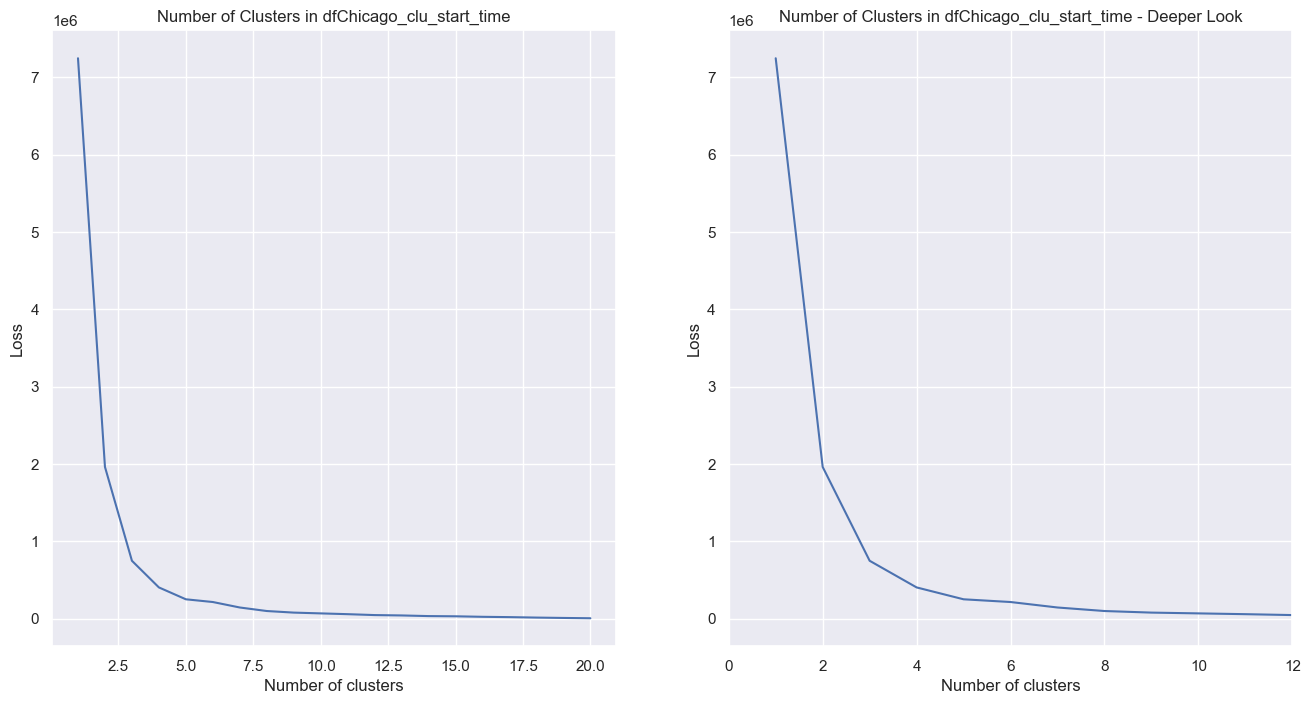

In [27]:
plot_best_fitting_number_of_clusters(dfChicago_clu_start_time_scaled, "in dfChicago_clu_start_time")

We find the optimal number of clusters by using the elbow method. In this method we look at he graph above and decide at which point on the x-axis (Number of clusters) the distortion decreases in a linear fashion. This means we decide at which point the graph loses its steep slope and continues to flatten linearly. We see, that the graph contiues to flatten out bewtween **two** and **four** . So taking **three** clusters as our baseline would be also meaningful and should fit. That is what we are doing now.

### 3.1.2 Computing Clusters with k-means++

In [28]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_start_time_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [29]:
# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_start_time_scaled)

In [30]:
# creating a column for the calculated clusters

dfChicago_clu_start_time.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_start_time

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1040107666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_start_time.loc[:, 'cluster_number'] = Clusters


start_time_hourly  cluster_number
0                        0               2
1                        0               2
2                        0               2
3                        0               2
4                        0               2
...                    ...             ...
7247312                 23               1
7247313                 23               1
7247314                 23               1
7247315                 23               1
7247316                 23               1

[7247317 rows x 2 columns]

### 3.1.3 Analyzing & Labeling Clusters

In [31]:
dfChicago_clu_start_time[dfChicago_clu_start_time['cluster_number']==0]['cluster_number'].count()

2607924

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


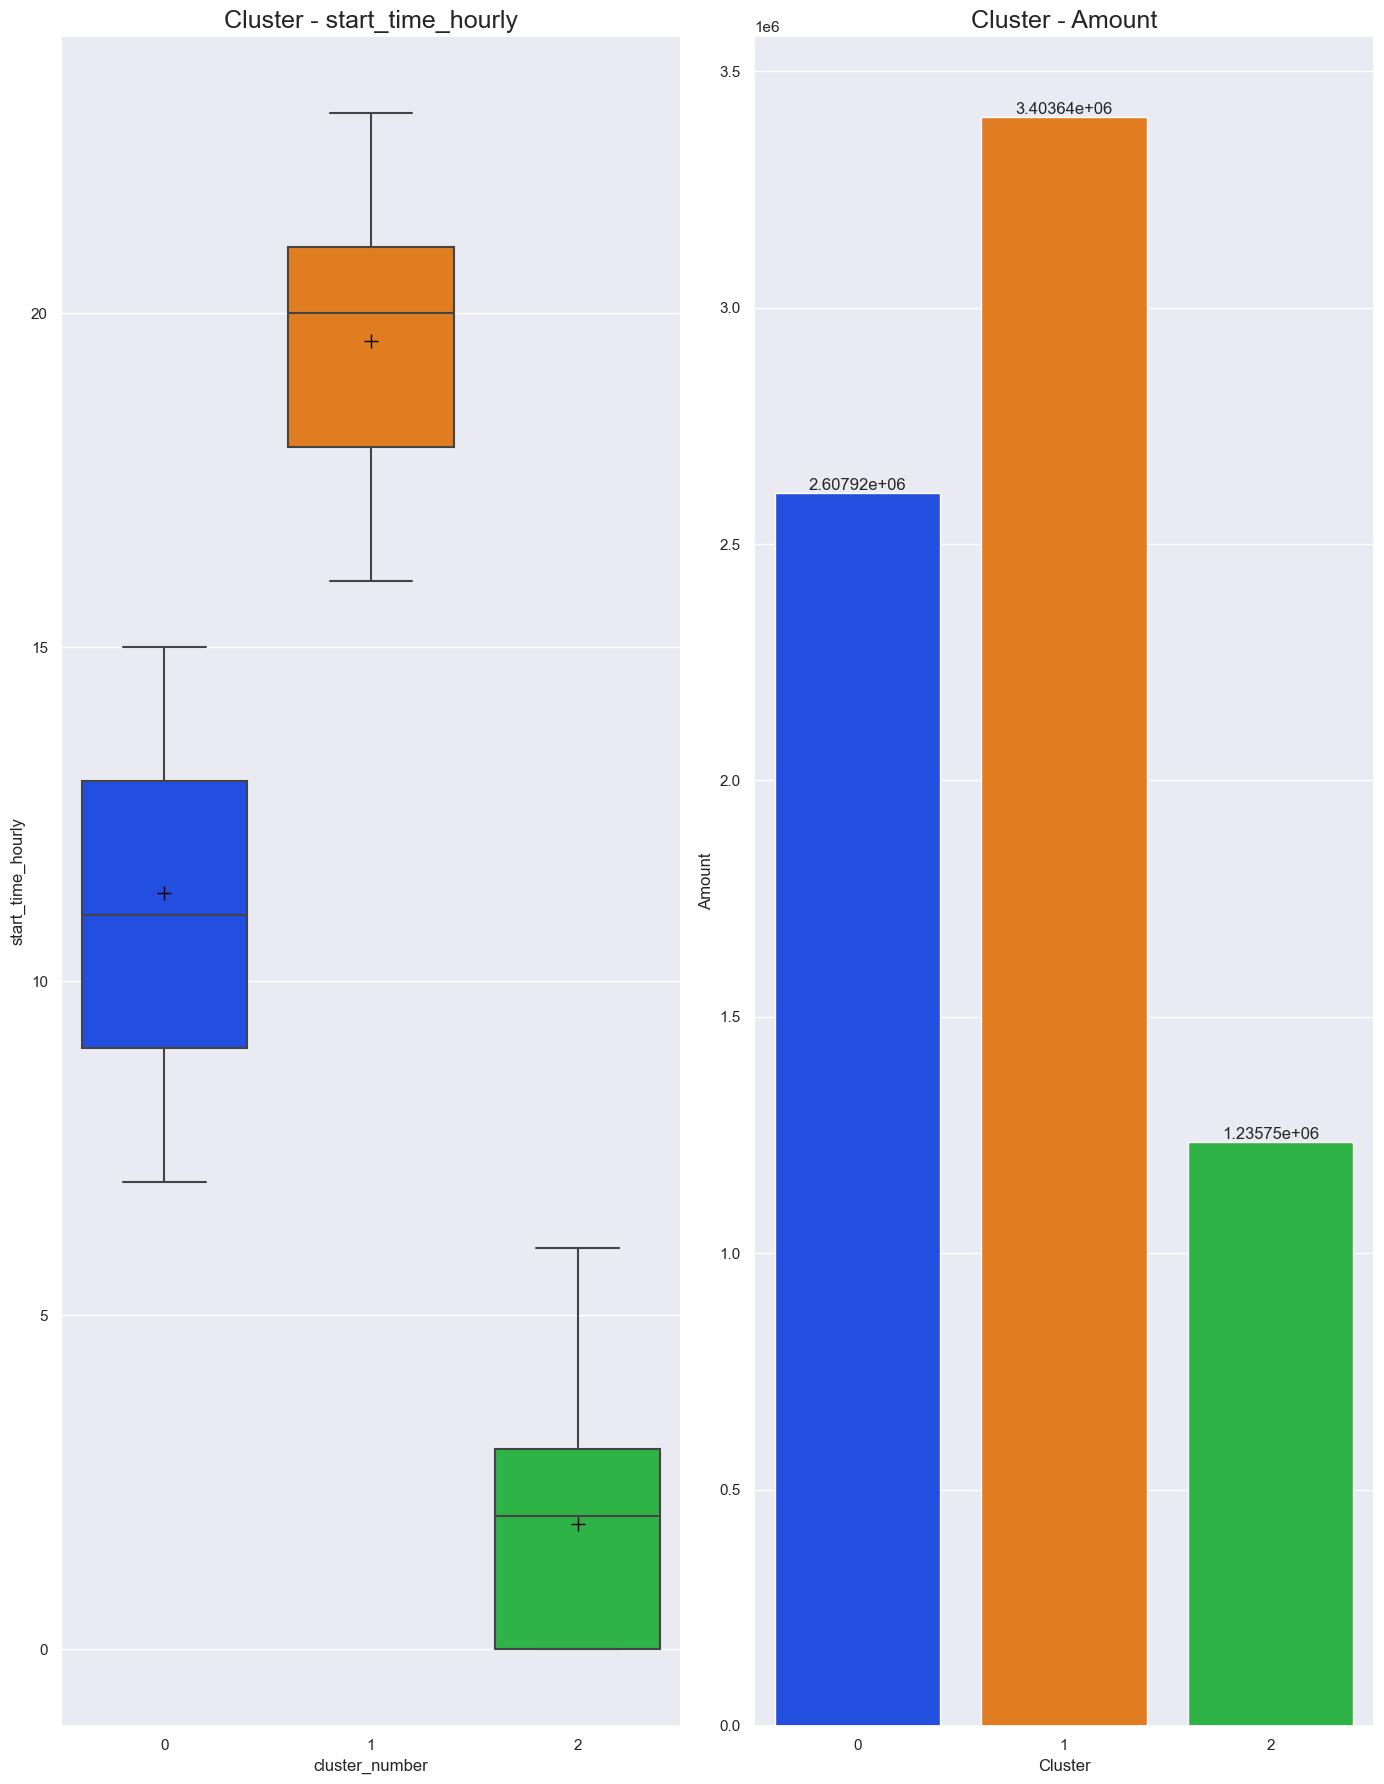

In [32]:
plot_information_about_clusters(dfChicago_clu_start_time, ['start_time_hourly'], 'cluster_number')

In [33]:
dfChicago_clu_start_time_quantiles = get_quantiles_of_clusters(dfChicago_clu_start_time, 3, 'cluster_number')
dfChicago_clu_start_time_quantiles.sort_values(by=['start_time_hourly'], ascending=False)

start_time_hourly  Amount Trips in Cluster  Percentage
Cluster                                                       
0              9.0 - 13.0                2607924.0       35.98
1             18.0 - 21.0                3403644.0       46.96
2               0.0 - 3.0                1235749.0       17.05

In [34]:
label_names = {'0': "Evening Commuters", 
               '1': "Night Riders - Party People",
               '2': "Morning Commuters"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_start_time['Cluster_Label'] = dfChicago_clu_start_time['cluster_number'].astype(str)
dfChicago_clu_start_time = dfChicago_clu_start_time.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\788367742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_start_time['Cluster_Label'] = dfChicago_clu_start_time['cluster_number'].astype(str)


In [35]:
dfChicago_clu_start_time_index = dfChicago_clu_start_time
dfChicago_clu_start_time_index['Trip_Index'] = dfChicago_clu_start_time_index.index
dfChicago_clu_start_time_index

start_time_hourly  cluster_number                Cluster_Label  \
0                        0               2            Morning Commuters   
1                        0               2            Morning Commuters   
2                        0               2            Morning Commuters   
3                        0               2            Morning Commuters   
4                        0               2            Morning Commuters   
...                    ...             ...                          ...   
7247312                 23               1  Night Riders - Party People   
7247313                 23               1  Night Riders - Party People   
7247314                 23               1  Night Riders - Party People   
7247315                 23               1  Night Riders - Party People   
7247316                 23               1  Night Riders - Party People   

         Trip_Index  
0                 0  
1                 1  
2                 2  
3                 3  
4                 4  
...             ...  
7247312     7247312  
7247313     7247313  
7247314     7247314  
7247315     7247315  
7247316     7247316  

[7247317 rows x 4 columns]

### 3.1.4 Plotting the Clustering Results

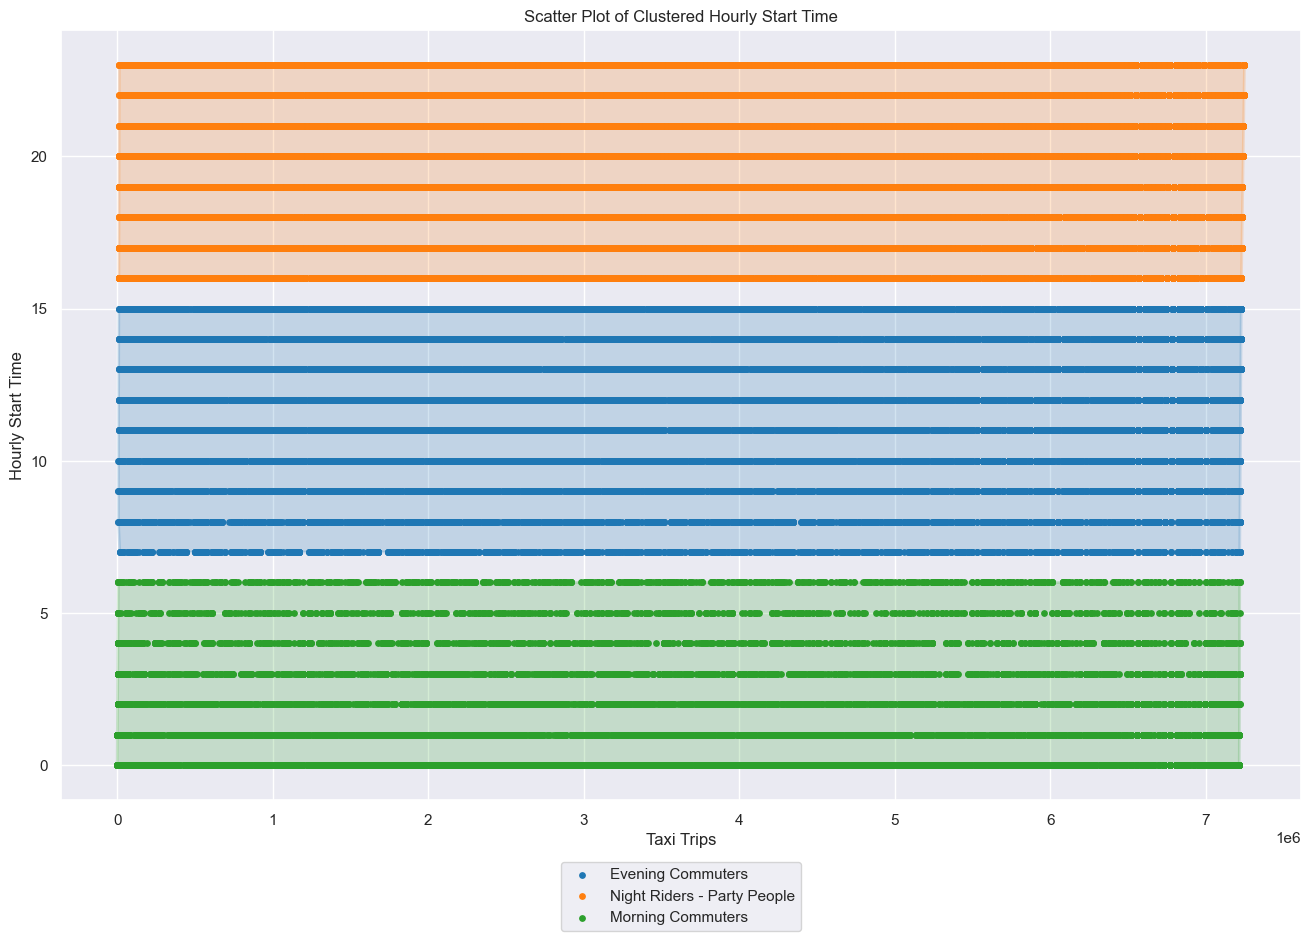

In [36]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_start_time_index.sample(n=100000), x_col='Trip_Index', y_col='start_time_hourly', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Hourly Start Time", plot_title='Scatter Plot of Clustered Hourly Start Time', leg_loc='lower center', anchor=(0.5, -0.18))

<hr style="border: 1px solid #8888;">

## 3.2 Second Cluster Analysis: `Trip_Minutes`

In [40]:
# Feature selection
dfChicago_clu_trip_minutes = dfChicago[['Trip_Minutes']]
dfChicago_clu_trip_minutes

Trip_Minutes
0                15.0
1                 4.0
2                 3.0
3                 4.0
4                 8.0
...               ...
7247312           3.0
7247313          19.0
7247314           9.0
7247315          12.0
7247316          11.0

[7247317 rows x 1 columns]

#### Scaling the Data

In [41]:
# Scaling the data
dfChicago_clu_trip_minutes_scaled = scaling_data(dfChicago_clu_trip_minutes)

### 3.2.1 Validation of Number of Clusters

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


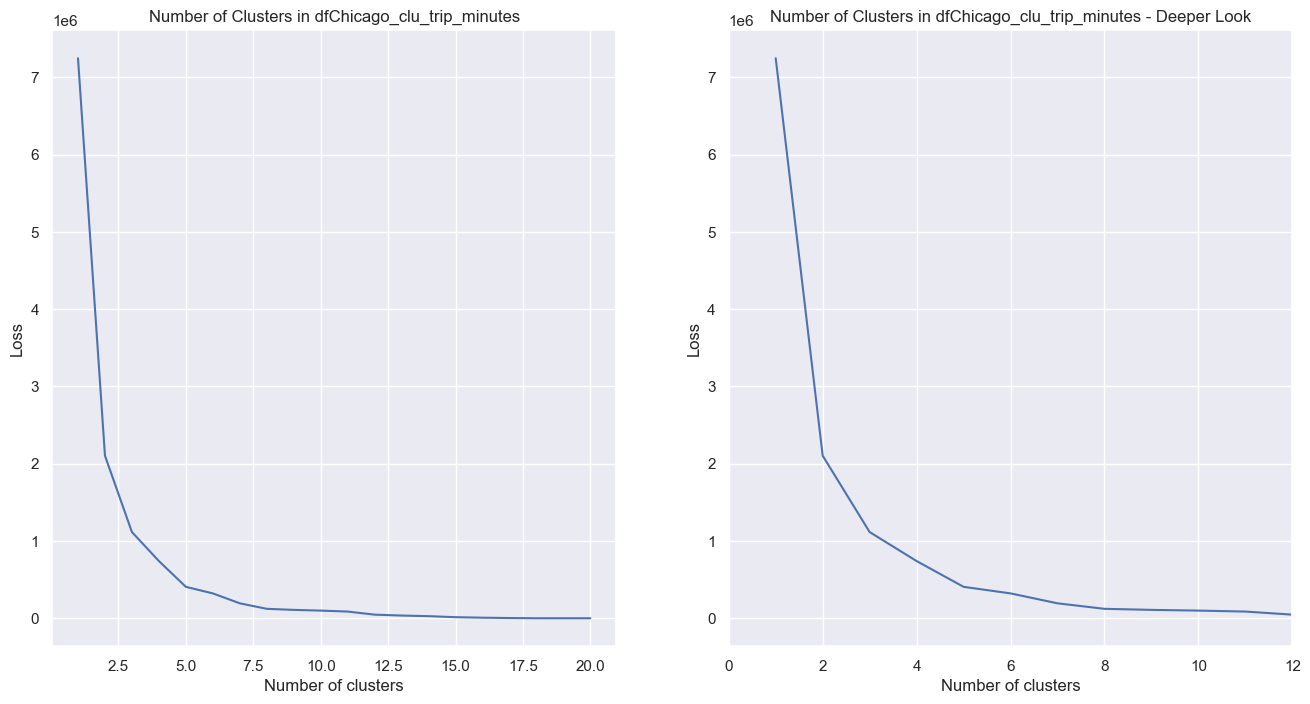

In [42]:
plot_best_fitting_number_of_clusters(dfChicago_clu_trip_minutes_scaled, "in dfChicago_clu_trip_minutes")

We again use the elbow method to declare the number of clusters. Looking at the plot above it seems that the elbow lies a **three** again.

### 3.2.2 Computing Clusters with k-means++

In [43]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_trip_minutes_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [44]:
# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_trip_minutes_scaled)

In [45]:
# creating a column for the calculated clusters

dfChicago_clu_trip_minutes.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_trip_minutes

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\3037118747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_minutes.loc[:, 'cluster_number'] = Clusters


Trip_Minutes  cluster_number
0                15.0               2
1                 4.0               1
2                 3.0               1
3                 4.0               1
4                 8.0               0
...               ...             ...
7247312           3.0               1
7247313          19.0               2
7247314           9.0               0
7247315          12.0               0
7247316          11.0               0

[7247317 rows x 2 columns]

### 3.2.3 Analyzing & Labeling Clusters

In [46]:
dfChicago_clu_trip_minutes[dfChicago_clu_trip_minutes['cluster_number']==0]['cluster_number'].count()

2583819

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


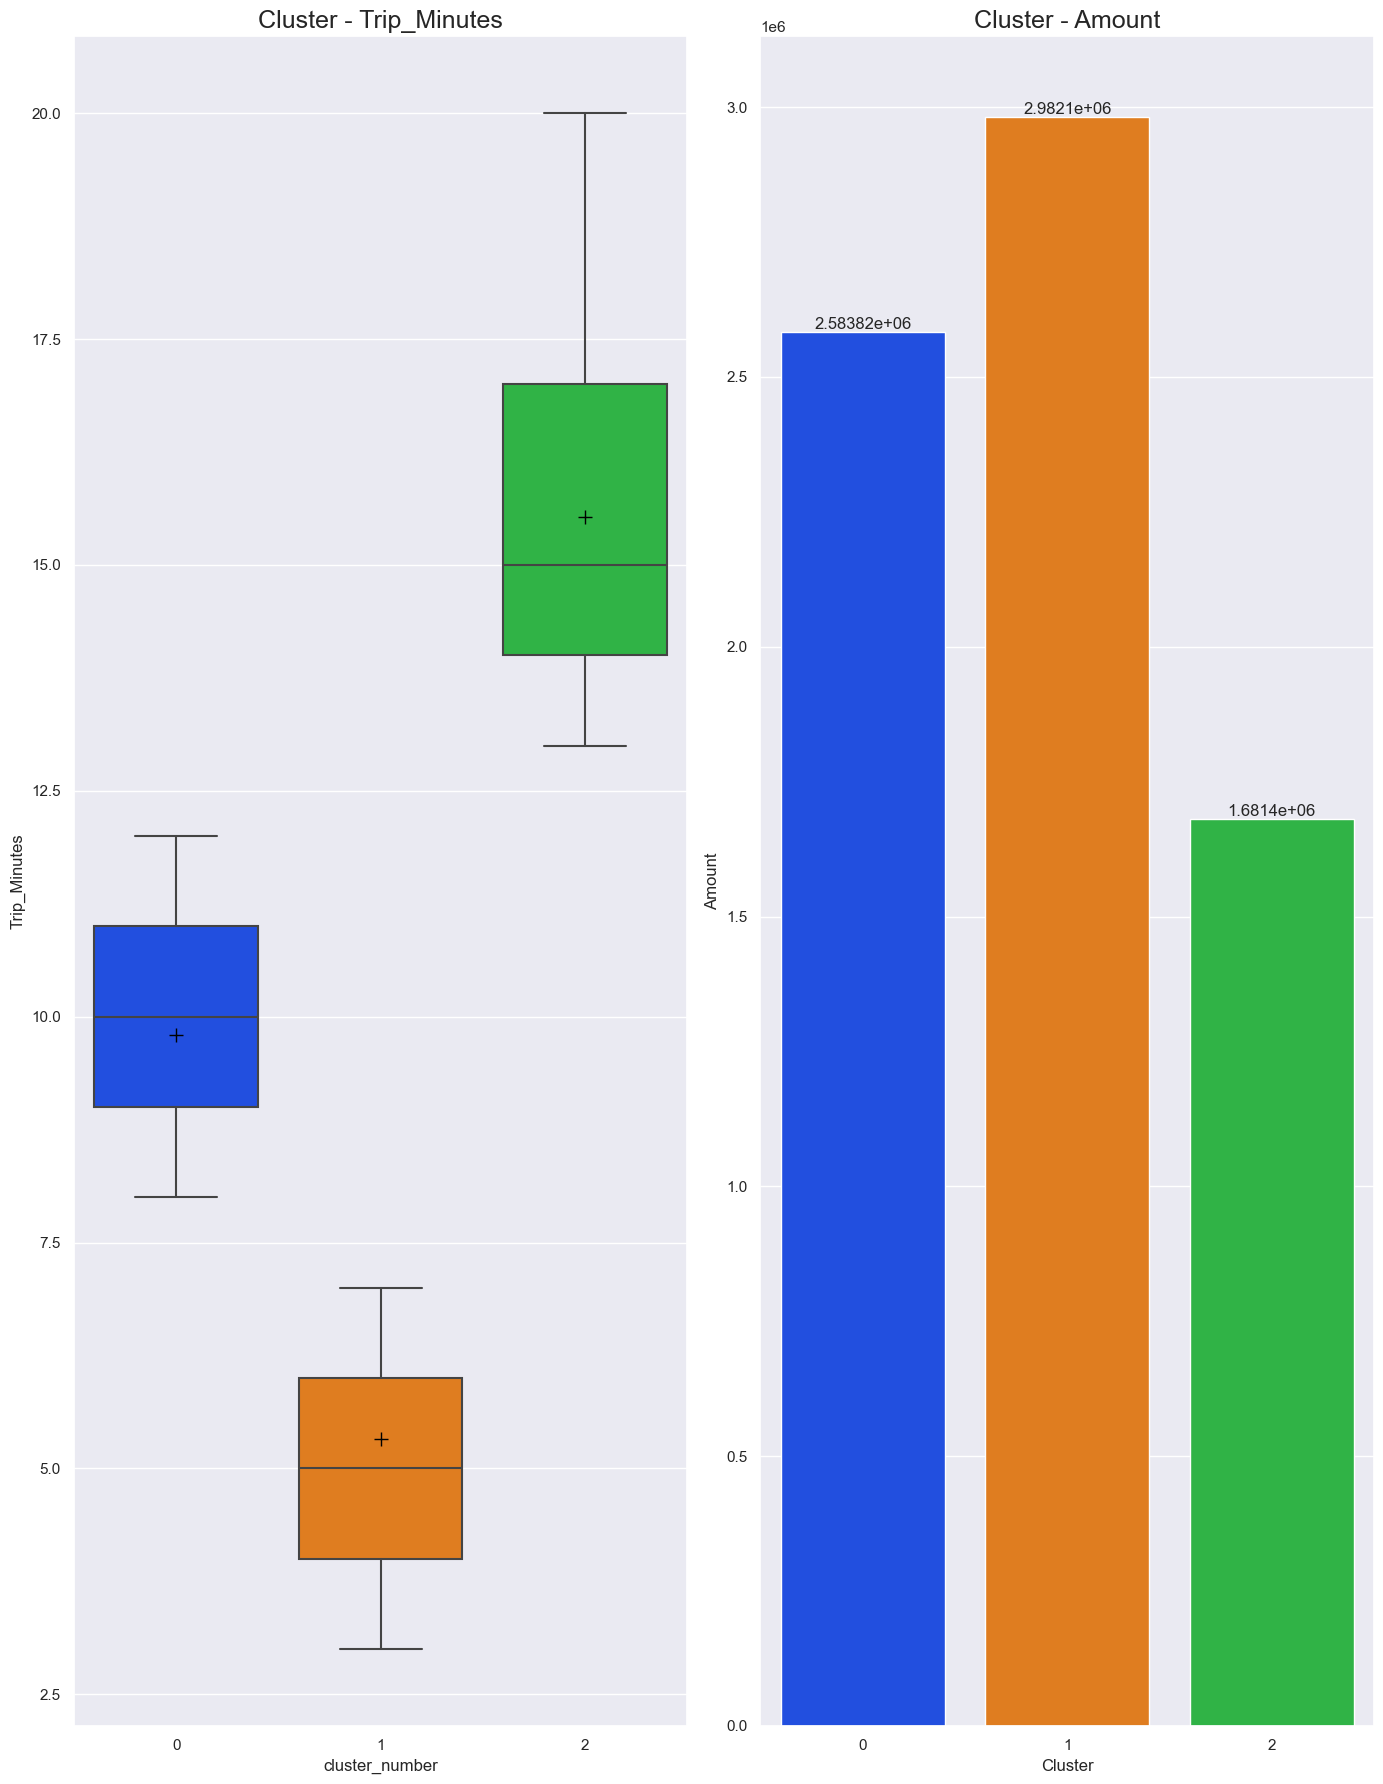

In [47]:
plot_information_about_clusters(dfChicago_clu_trip_minutes, ['Trip_Minutes'], 'cluster_number')

In [48]:
dfChicago_clu_trip_minutes_quantiles = get_quantiles_of_clusters(dfChicago_clu_trip_minutes, 3, 'cluster_number')
dfChicago_clu_trip_minutes_quantiles.sort_values(by=['Trip_Minutes'], ascending=False)


Trip_Minutes  Amount Trips in Cluster  Percentage
Cluster                                                  
0         9.0 - 11.0                2583819.0       35.65
1          4.0 - 6.0                2982100.0       41.15
2        14.0 - 17.0                1681398.0       23.20

In [49]:
label_names = {'0': "Short Trips", 
               '1': "Medium Trips",
               '2': "Long Trips"
               }

# integrating our labeled clusters in the dataframe
dfChicago_clu_trip_minutes['Cluster_Label'] = dfChicago_clu_trip_minutes['cluster_number'].astype(str)
dfChicago_clu_trip_minutes = dfChicago_clu_trip_minutes.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\4245702400.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_minutes['Cluster_Label'] = dfChicago_clu_trip_minutes['cluster_number'].astype(str)


In [50]:
dfChicago_clu_trip_minutes_index = dfChicago_clu_trip_minutes
dfChicago_clu_trip_minutes_index['Trip_Index'] = dfChicago_clu_trip_minutes_index.index
dfChicago_clu_trip_minutes_index

Trip_Minutes  cluster_number Cluster_Label  Trip_Index
0                15.0               2    Long Trips           0
1                 4.0               1  Medium Trips           1
2                 3.0               1  Medium Trips           2
3                 4.0               1  Medium Trips           3
4                 8.0               0   Short Trips           4
...               ...             ...           ...         ...
7247312           3.0               1  Medium Trips     7247312
7247313          19.0               2    Long Trips     7247313
7247314           9.0               0   Short Trips     7247314
7247315          12.0               0   Short Trips     7247315
7247316          11.0               0   Short Trips     7247316

[7247317 rows x 4 columns]

### 3.2.4 Plotting the Clustering Results

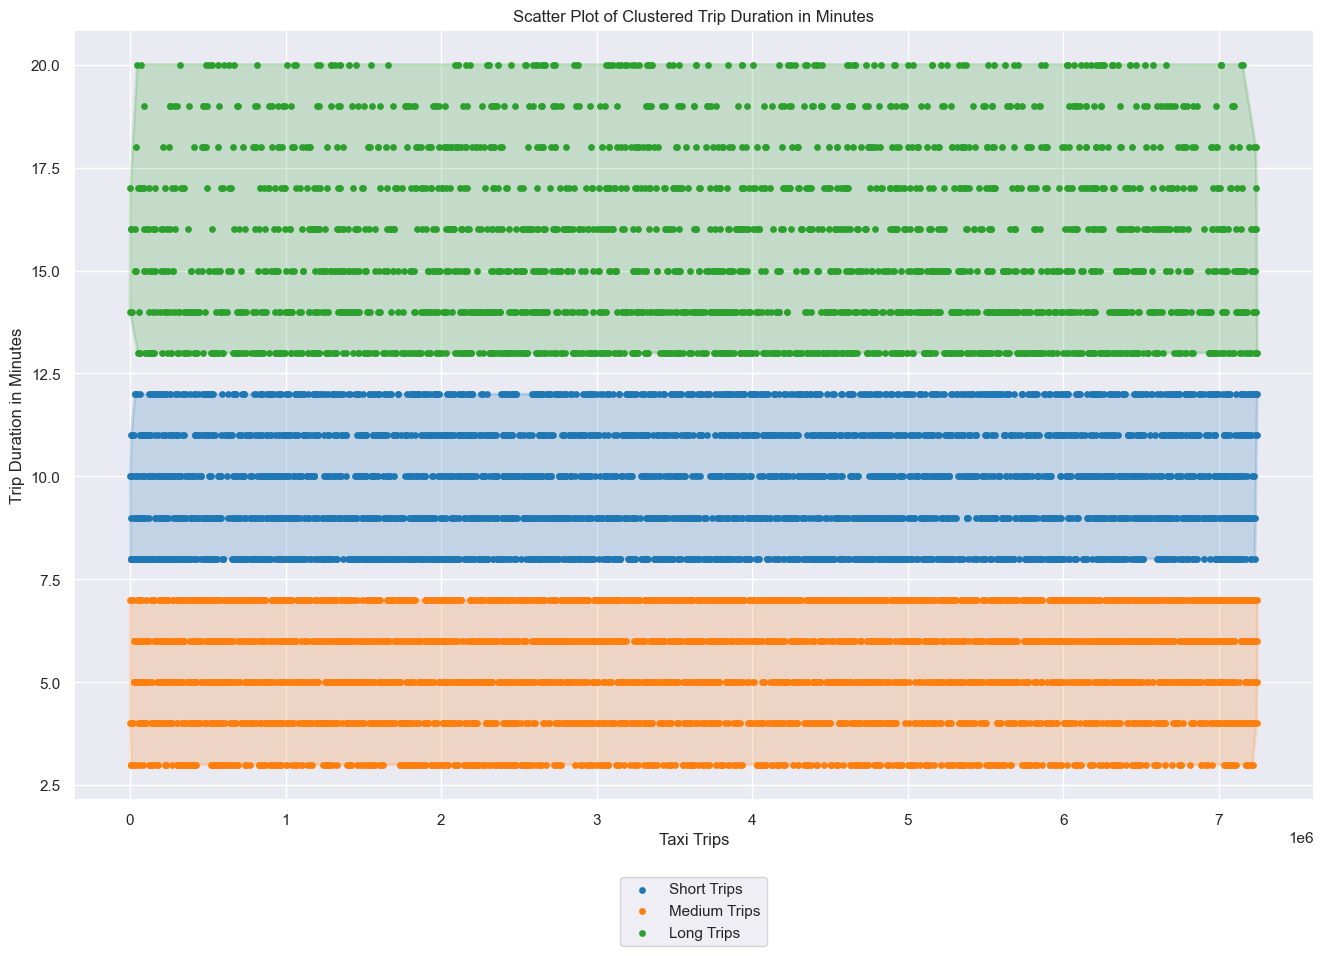

In [51]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_trip_minutes_index.sample(n=10000), x_col='Trip_Index', y_col='Trip_Minutes', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Duration in Minutes", plot_title='Scatter Plot of Clustered Trip Duration in Minutes', leg_loc='lower center', anchor=(0.5, -0.2))

<hr style="border: 1px solid #8888;">

## 3.3 Third Cluster Analysis: `Trip_Miles`

In [52]:
# Feature selection
dfChicago_clu_trip_miles = dfChicago[['Trip_Miles']]
dfChicago_clu_trip_miles

Trip_Miles
0               2.7
1               0.4
2               1.0
3               0.3
4               0.8
...             ...
7247312         0.5
7247313         5.1
7247314         1.4
7247315         2.0
7247316         3.5

[7247317 rows x 1 columns]

#### Scaling the Data

In [53]:
# Scaling the data
dfChicago_clu_trip_miles_scaled = scaling_data(dfChicago_clu_trip_miles)

### 3.3.1 Validation of Number of Clusters

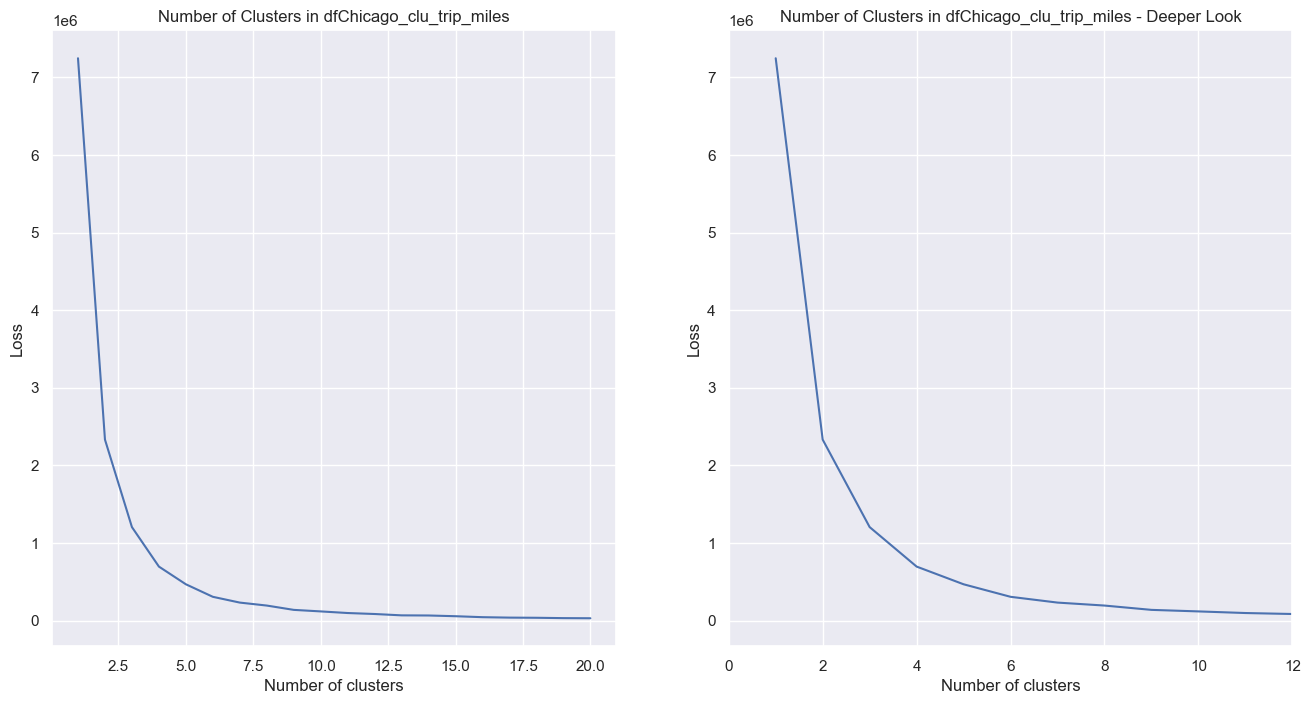

In [54]:
plot_best_fitting_number_of_clusters(dfChicago_clu_trip_miles_scaled, "in dfChicago_clu_trip_miles")

We again use the elbow method to declare the number of clusters. Looking at the plot above it seems that the elbow lies a **three** again.

### 3.3.2 Computing Clusters with k-means++

In [55]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_trip_miles_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_trip_miles_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [56]:
# creating a column for the calculated clusters

dfChicago_clu_trip_miles.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_trip_miles

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\3326964530.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_miles.loc[:, 'cluster_number'] = Clusters


Trip_Miles  cluster_number
0               2.7               0
1               0.4               2
2               1.0               2
3               0.3               2
4               0.8               2
...             ...             ...
7247312         0.5               2
7247313         5.1               1
7247314         1.4               2
7247315         2.0               0
7247316         3.5               1

[7247317 rows x 2 columns]

### 3.3.3 Analyzing & Labeling Clusters

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


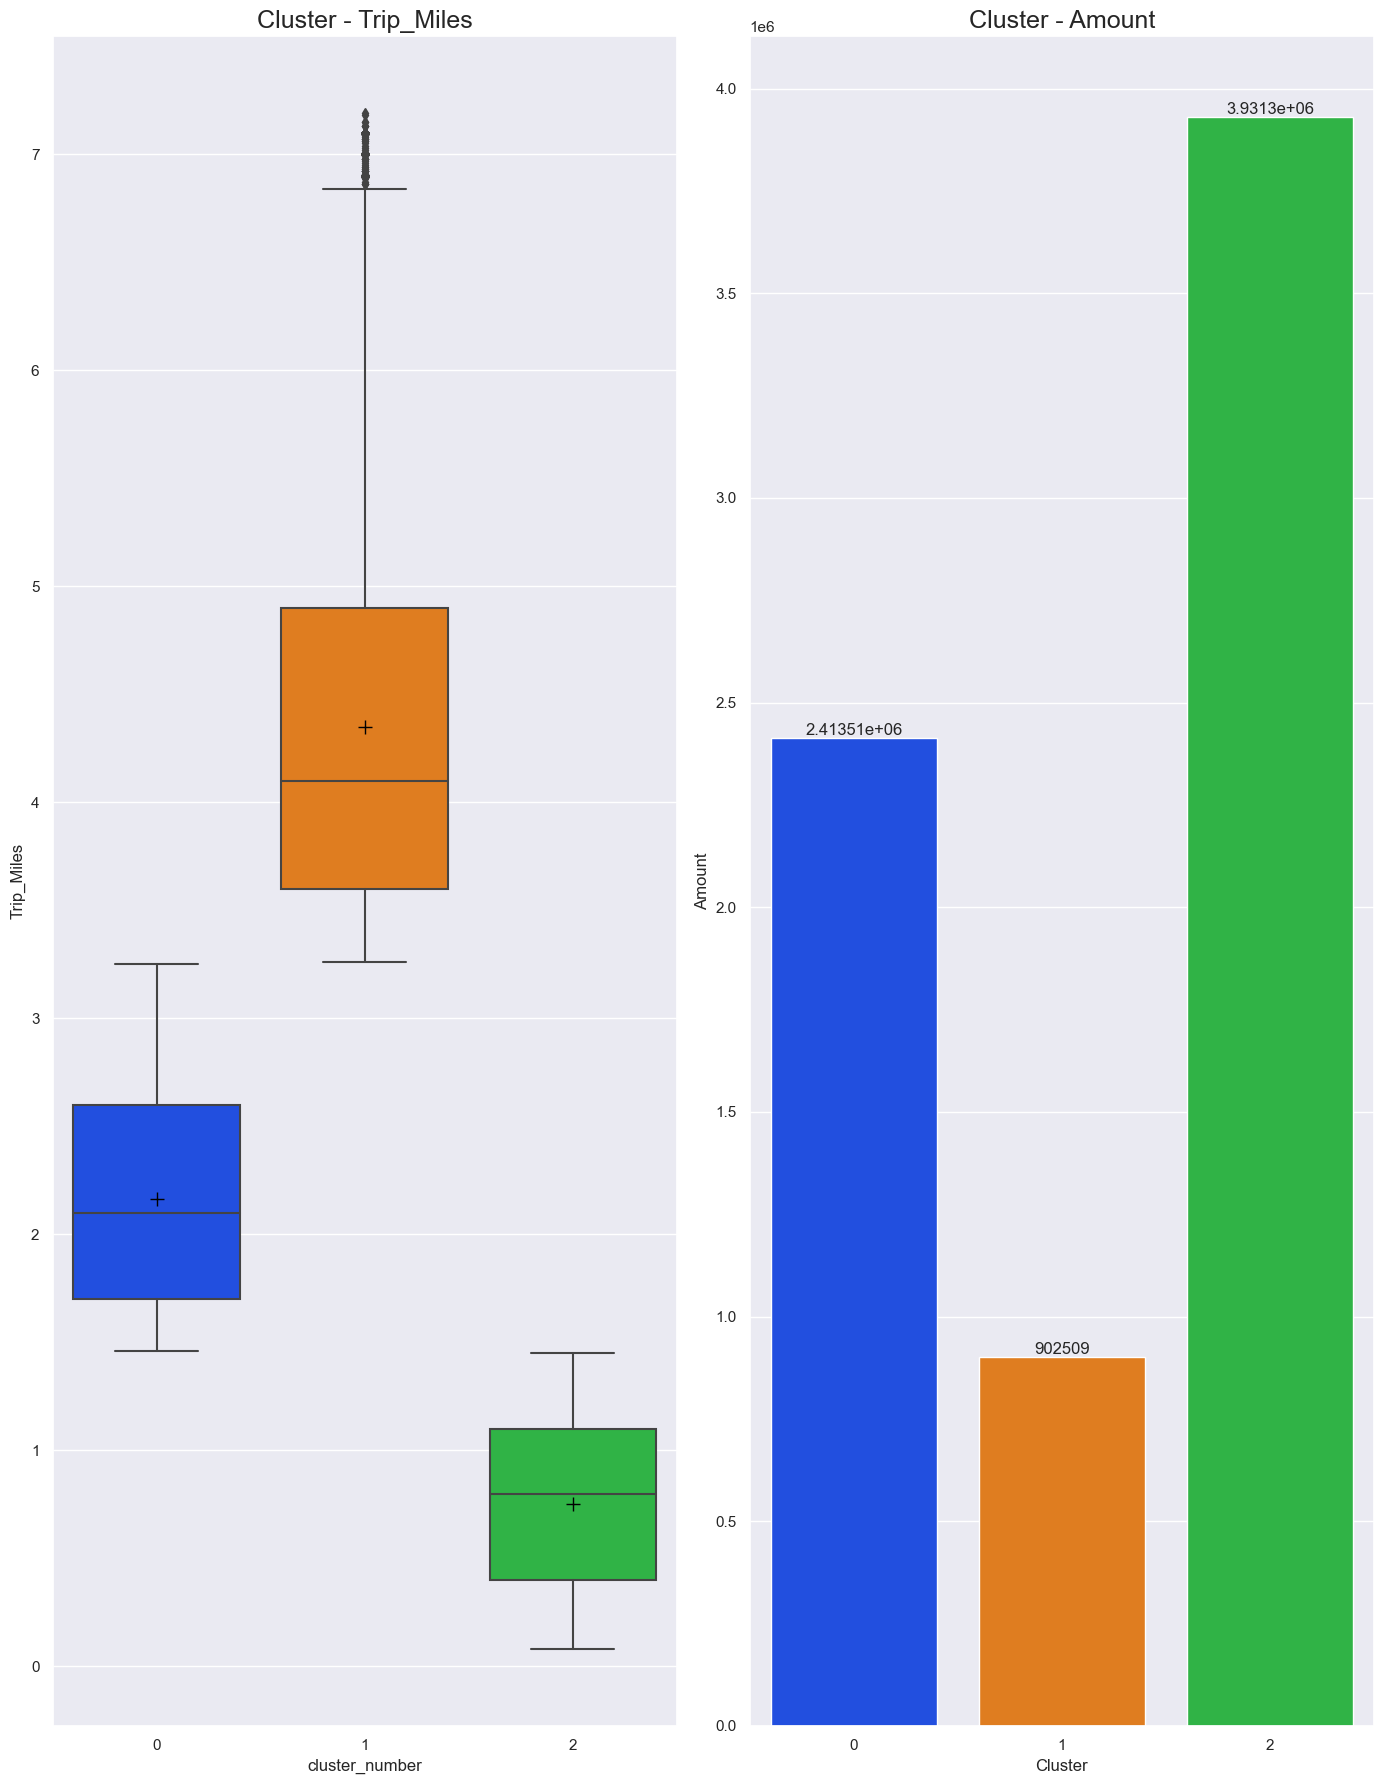

In [57]:
plot_information_about_clusters(dfChicago_clu_trip_miles, ['Trip_Miles'], 'cluster_number')

In [58]:
dfChicago_clu_trip_miles_quantiles = get_quantiles_of_clusters(dfChicago_clu_trip_miles, 3, 'cluster_number')
dfChicago_clu_trip_miles_quantiles.sort_values(by=['Trip_Miles'], ascending=False)

Trip_Miles  Amount Trips in Cluster  Percentage
Cluster                                                
1        3.6 - 4.9                 902509.0       12.45
0        1.7 - 2.6                2413510.0       33.30
2        0.4 - 1.1                3931298.0       54.24

In [59]:
label_names = {'0': "Short Trips", 
               '1': "Medium Trips",
               '2': "Long Trips"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_trip_miles['Cluster_Label'] = dfChicago_clu_trip_miles['cluster_number'].astype(str)
dfChicago_clu_trip_miles = dfChicago_clu_trip_miles.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\2306004952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_miles['Cluster_Label'] = dfChicago_clu_trip_miles['cluster_number'].astype(str)


In [60]:
dfChicago_clu_trip_miles_index = dfChicago_clu_trip_miles
dfChicago_clu_trip_miles_index['Trip_Index'] = dfChicago_clu_trip_miles_index.index
dfChicago_clu_trip_miles_index

Trip_Miles  cluster_number Cluster_Label  Trip_Index
0               2.7               0   Short Trips           0
1               0.4               2    Long Trips           1
2               1.0               2    Long Trips           2
3               0.3               2    Long Trips           3
4               0.8               2    Long Trips           4
...             ...             ...           ...         ...
7247312         0.5               2    Long Trips     7247312
7247313         5.1               1  Medium Trips     7247313
7247314         1.4               2    Long Trips     7247314
7247315         2.0               0   Short Trips     7247315
7247316         3.5               1  Medium Trips     7247316

[7247317 rows x 4 columns]

### 3.3.4 Plotting the Clustering Results

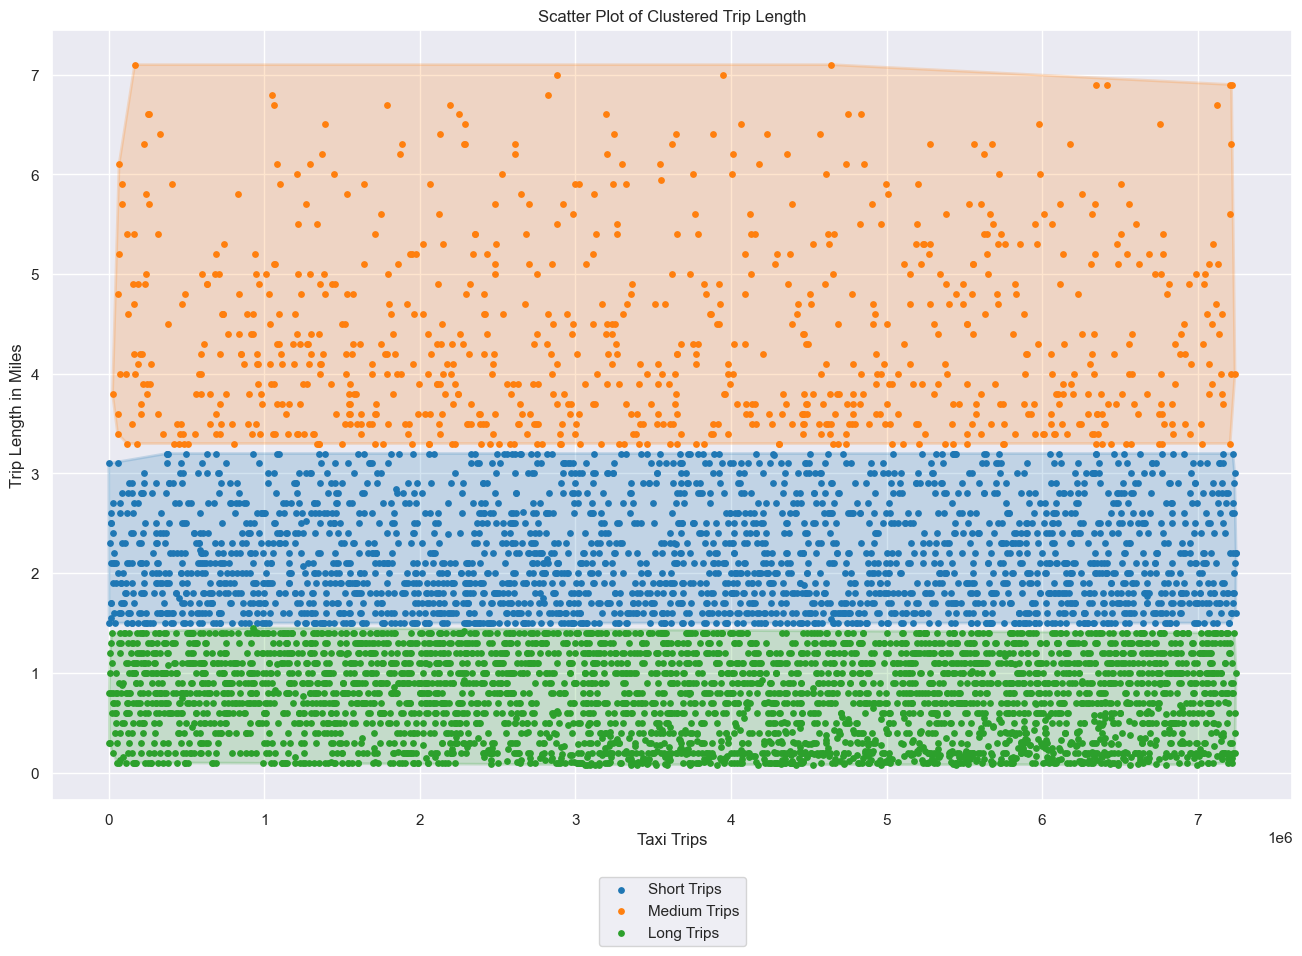

In [61]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_trip_miles_index.sample(n=7000), x_col='Trip_Index', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Length in Miles", plot_title='Scatter Plot of Clustered Trip Length', leg_loc='lower center', anchor=(0.5, -0.2))

<hr style="border: 1px solid #8888;">

## 3.4 Fourth Cluster Analysis: `start_time_hourly`, `Trip_Seconds`, `Trip_Miles`

In [62]:
# Feature selection
dfChicago_clu_combined = dfChicago[['start_time_hourly', 'Trip_Minutes' ,'Trip_Miles']]
dfChicago_clu_combined

start_time_hourly  Trip_Minutes  Trip_Miles
0                        0          15.0         2.7
1                        0           4.0         0.4
2                        0           3.0         1.0
3                        0           4.0         0.3
4                        0           8.0         0.8
...                    ...           ...         ...
7247312                 23           3.0         0.5
7247313                 23          19.0         5.1
7247314                 23           9.0         1.4
7247315                 23          12.0         2.0
7247316                 23          11.0         3.5

[7247317 rows x 3 columns]

#### Scaling the Data

In [63]:
# Scaling the data
dfChicago_clu_combined_scaled = scaling_data(dfChicago_clu_combined)

### 3.4.1 Validation of Number of Clusters

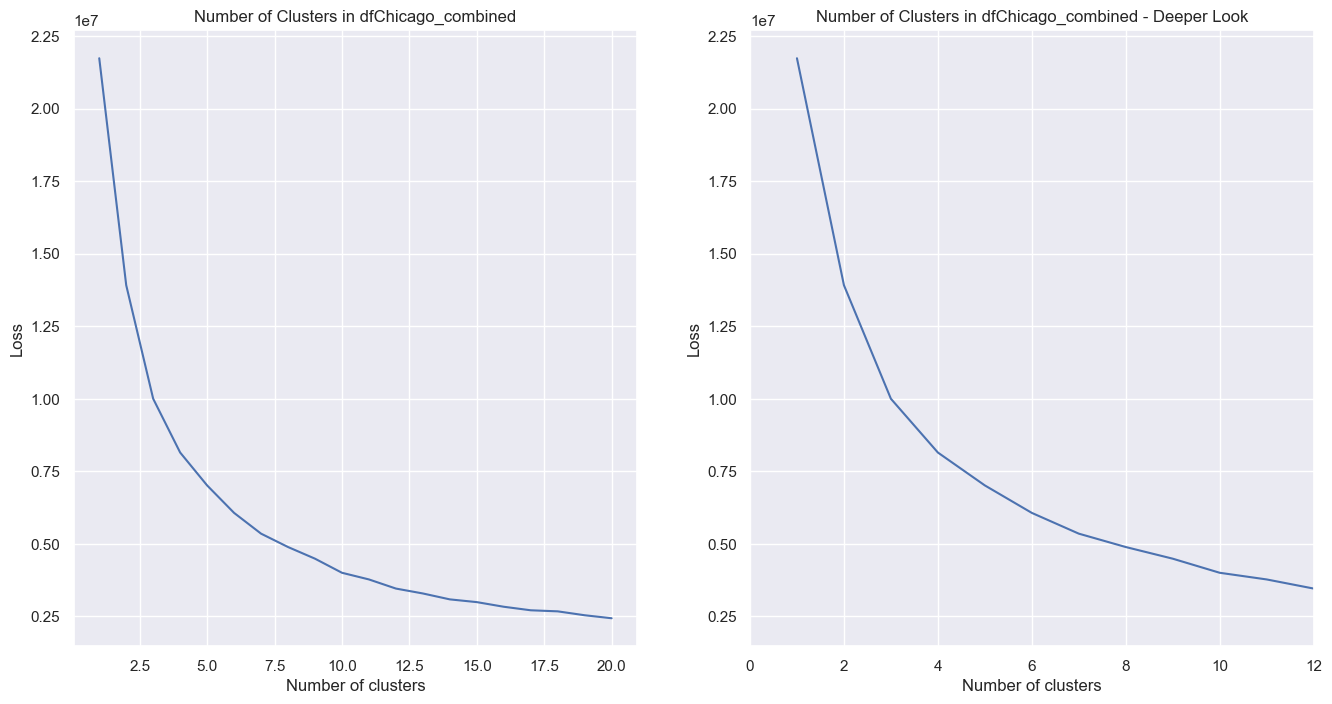

In [64]:
plot_best_fitting_number_of_clusters(dfChicago_clu_combined_scaled, "in dfChicago_combined")

We again use the elbow method to declare the number of clusters. Looking at the plot above it seems that the elbow lies bewtween **three** and **five**, therefore we choose **four** as the numebr of clusters.

### 3.4.2 Computing Clusters with k-means++

In [65]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=4,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_combined_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_combined_scaled)

# creating a column for the calculated clusters

dfChicago_clu_combined.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_combined

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1325623314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_combined.loc[:, 'cluster_number'] = Clusters


start_time_hourly  Trip_Minutes  Trip_Miles  cluster_number
0                        0          15.0         2.7               0
1                        0           4.0         0.4               0
2                        0           3.0         1.0               0
3                        0           4.0         0.3               0
4                        0           8.0         0.8               0
...                    ...           ...         ...             ...
7247312                 23           3.0         0.5               2
7247313                 23          19.0         5.1               3
7247314                 23           9.0         1.4               2
7247315                 23          12.0         2.0               1
7247316                 23          11.0         3.5               1

[7247317 rows x 4 columns]

### 3.4.3 Analyzing & Labeling Clusters

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


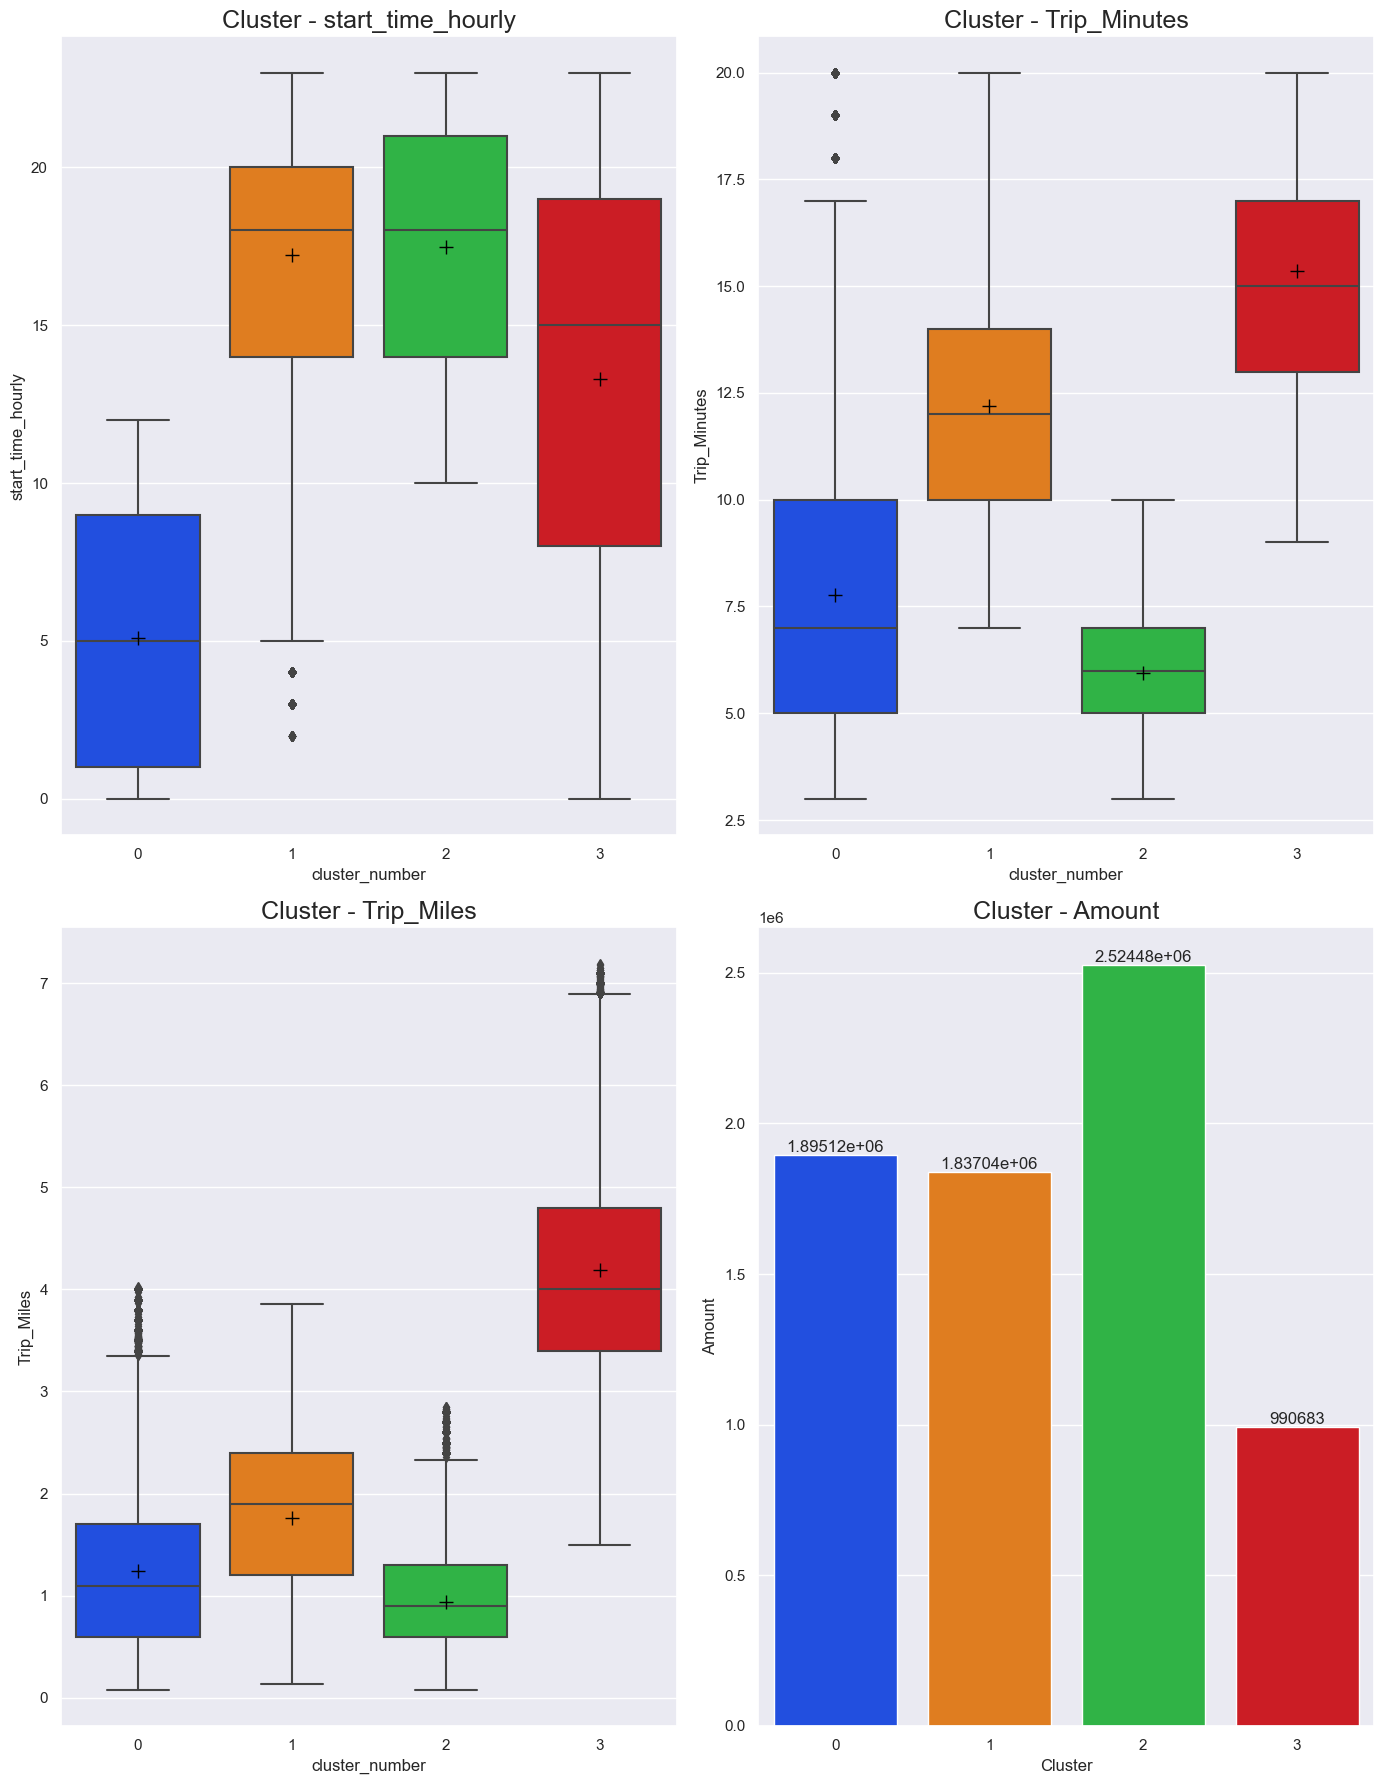

In [66]:
plot_information_about_clusters(dfChicago_clu_combined, ['start_time_hourly', 'Trip_Minutes' ,'Trip_Miles'], 'cluster_number')

In [67]:
dfChicago_clu_combined_quantiles = get_quantiles_of_clusters(dfChicago_clu_combined, 4, 'cluster_number')
dfChicago_clu_combined_quantiles.sort_values(by=['start_time_hourly', 'Trip_Minutes'], ascending=False)

start_time_hourly Trip_Minutes Trip_Miles  Amount Trips in Cluster  \
Cluster                                                                      
3              8.0 - 19.0  13.0 - 17.0  3.4 - 4.8                 990683.0   
2             14.0 - 21.0    5.0 - 7.0  0.6 - 1.3                2524479.0   
1             14.0 - 20.0  10.0 - 14.0  1.2 - 2.4                1837037.0   
0               1.0 - 9.0   5.0 - 10.0  0.6 - 1.7                1895118.0   

         Percentage  
Cluster              
3             13.67  
2             34.83  
1             25.35  
0             26.15

In [68]:
label_names = {'0': "Evening Commuters", 
               '1': "Short to Medium Rides (2 - 4 Miles)",
               '2': "Long Rides (7 - 11 miles)",
               '3': "Party People / Night Riders",
               '4': "Morning Commuters"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_combined['Cluster_Label'] = dfChicago_clu_combined['cluster_number'].astype(str)
dfChicago_clu_combined = dfChicago_clu_combined.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\567415022.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_combined['Cluster_Label'] = dfChicago_clu_combined['cluster_number'].astype(str)


### 3.4.4 Plotting the Clustering Results

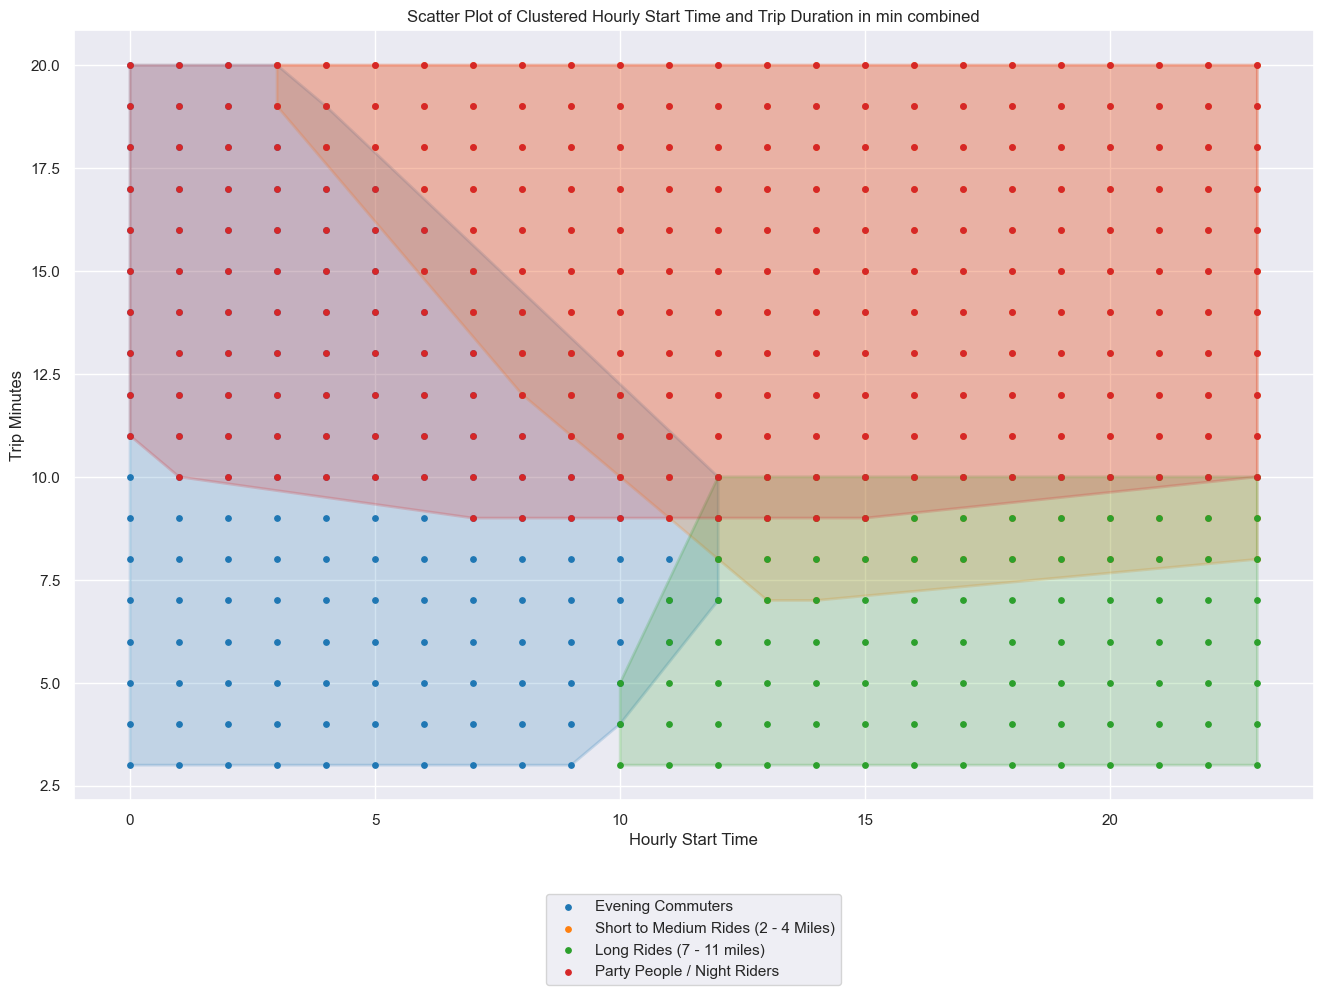

In [70]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_combined.sample(n=100_000), x_col='start_time_hourly', y_col='Trip_Minutes', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Minutes", plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Duration in min combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

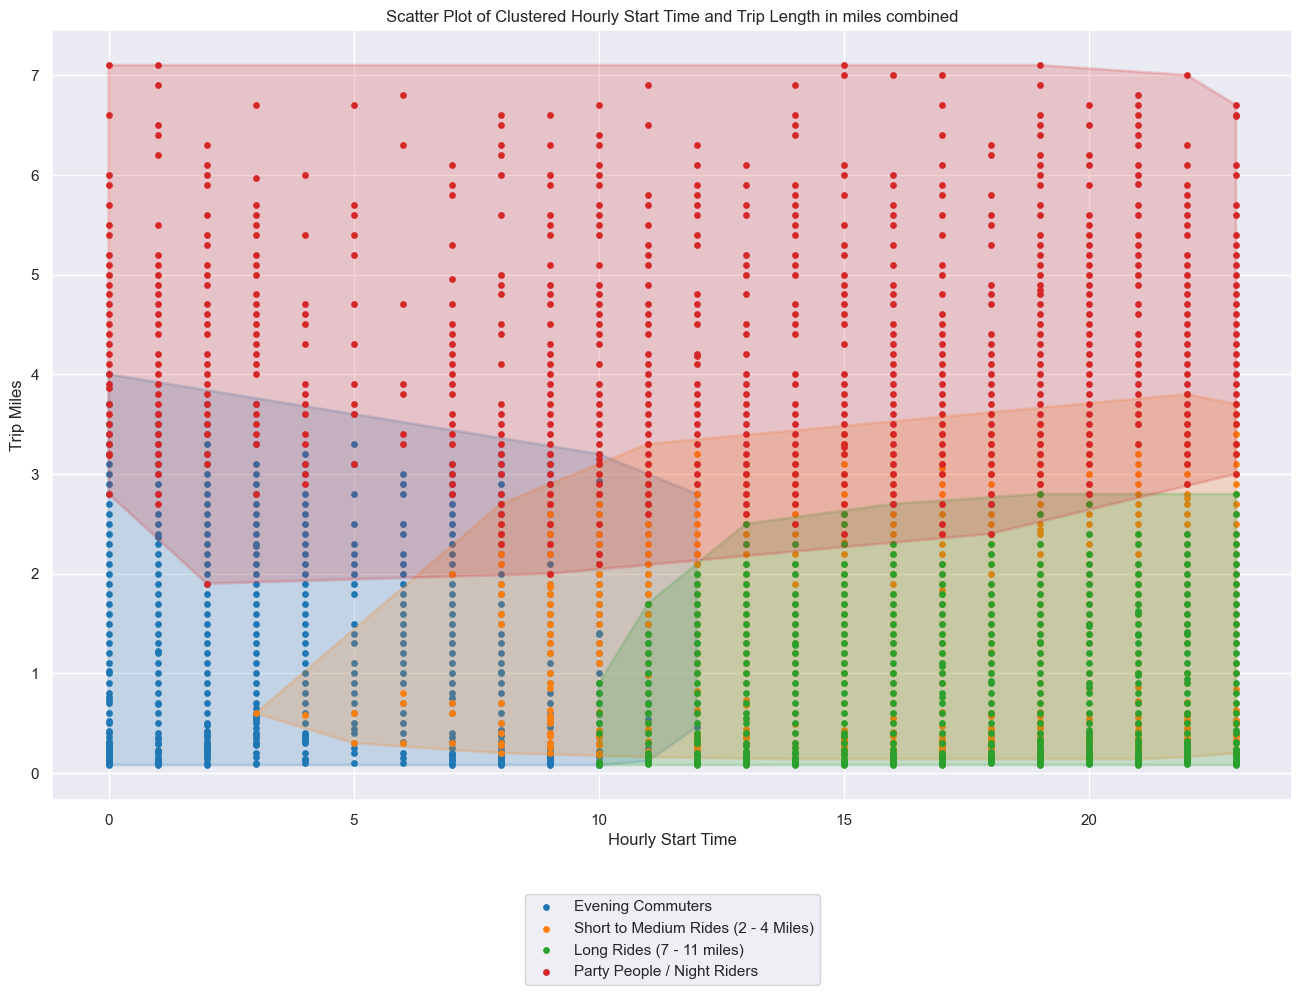

In [71]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_combined.sample(n=10_000), x_col='start_time_hourly', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Length in miles combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

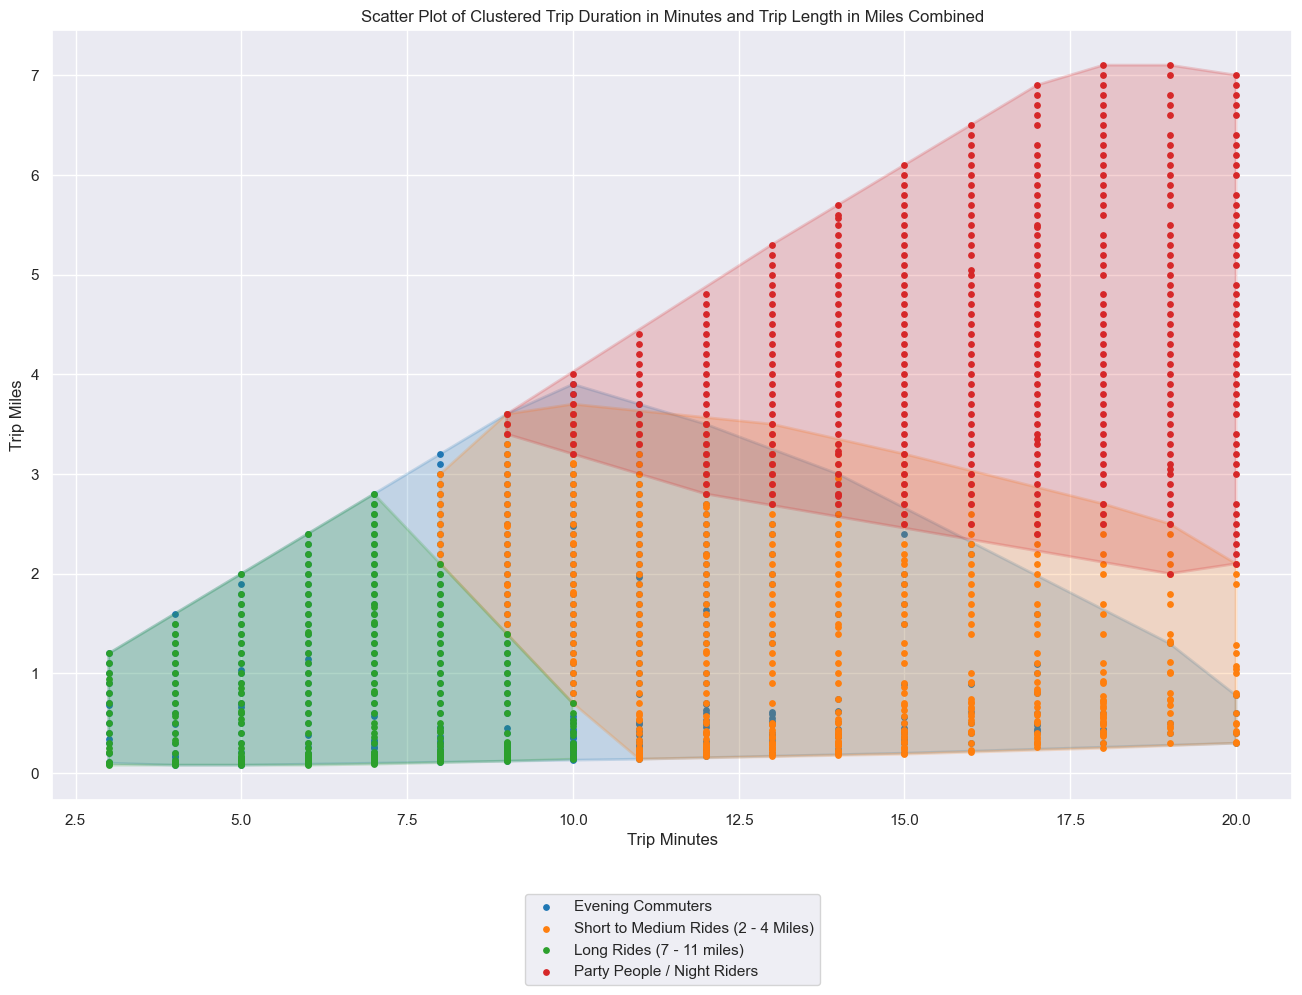

In [78]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_combined.sample(n=10_000), x_col='Trip_Minutes', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Minutes', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Trip Duration in Minutes and Trip Length in Miles Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


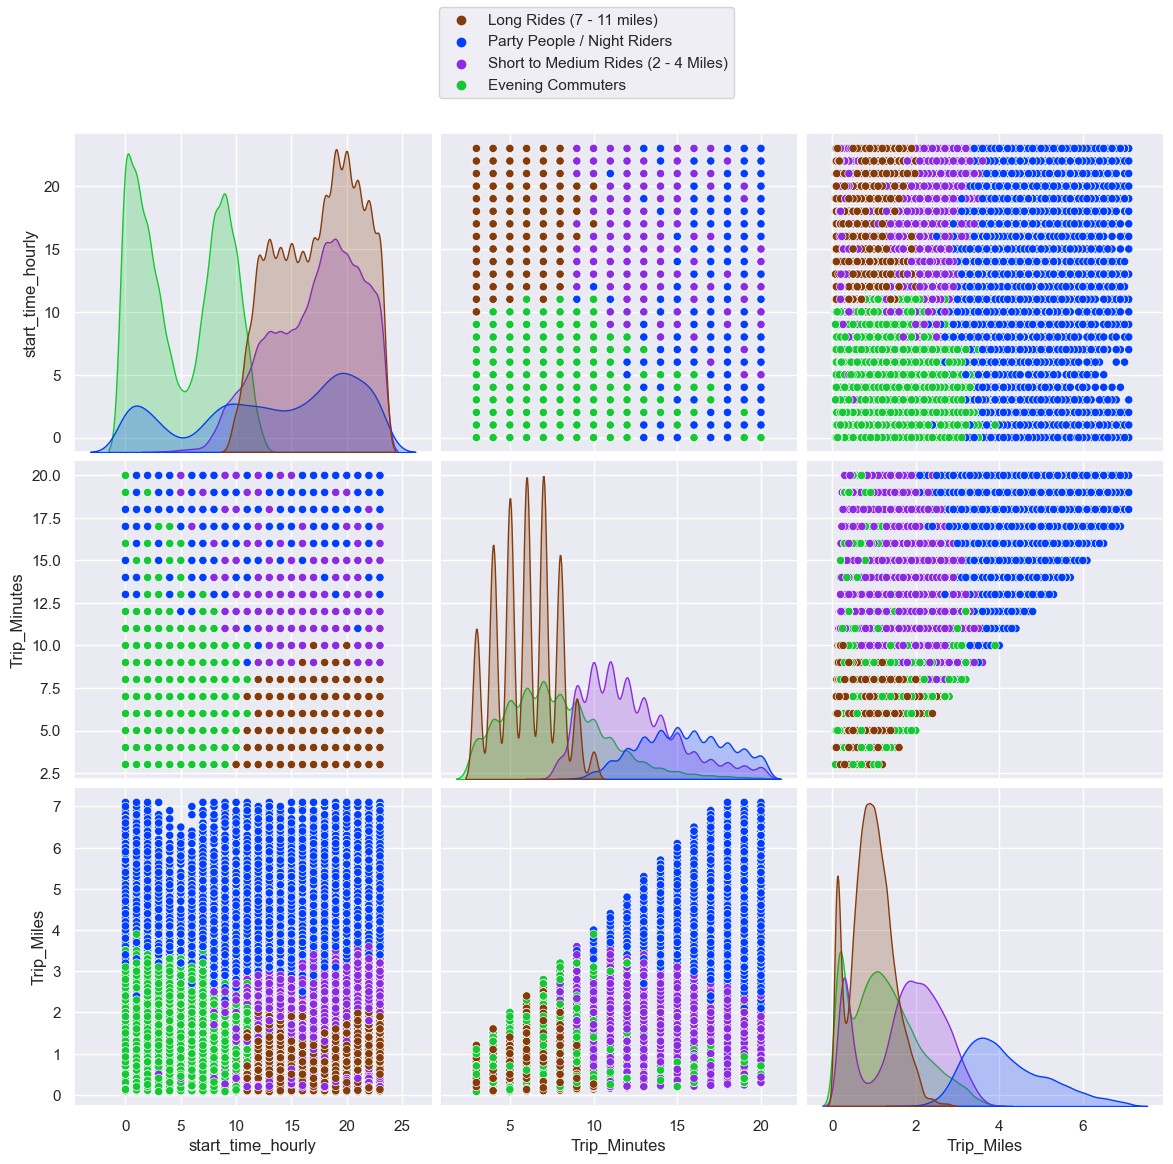

In [79]:
colors = {'Evening Commuters' : '#16C835',
          'Morning Commuters' : '#FF7C00',
          'Short to Medium Rides (2 - 4 Miles)' : '#8B2BE2',
          'Long Rides (7 - 11 miles)' : '#843C0C',
          'Party People / Night Riders': '#023EFF'}

g = sns.pairplot(data=dfChicago_clu_combined[['start_time_hourly', 'Trip_Minutes' ,'Trip_Miles', 'Cluster_Label']].sample(100_000),
             hue = 'Cluster_Label', palette=colors, height=4, aspect=1)

#styling the output
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.subplots_adjust(top=0.89, bottom=0.08)

<hr style="border: 1px solid #8888;">

## 3.5 Fifth Cluster Analysis: `distance_to_city_center_pickup`

In [80]:
# Feature selection
dfChicago_clu_distance_to_city_center_pickup = dfChicago[['distance_to_city_center_pickup']]
dfChicago_clu_distance_to_city_center_pickup

distance_to_city_center_pickup
0                              1.614272
1                              3.617721
2                              2.685629
3                              0.495382
4                              4.526819
...                                 ...
7247312                        0.495382
7247313                        4.435183
7247314                        0.893287
7247315                        0.725199
7247316                        1.344327

[7247317 rows x 1 columns]

#### Scaling the Data

In [81]:
# Scaling the data
dfChicago_clu_distance_to_city_center_pickup_scaled = scaling_data(dfChicago_clu_distance_to_city_center_pickup)

### 3.5.1 Validation of Number of Clusters

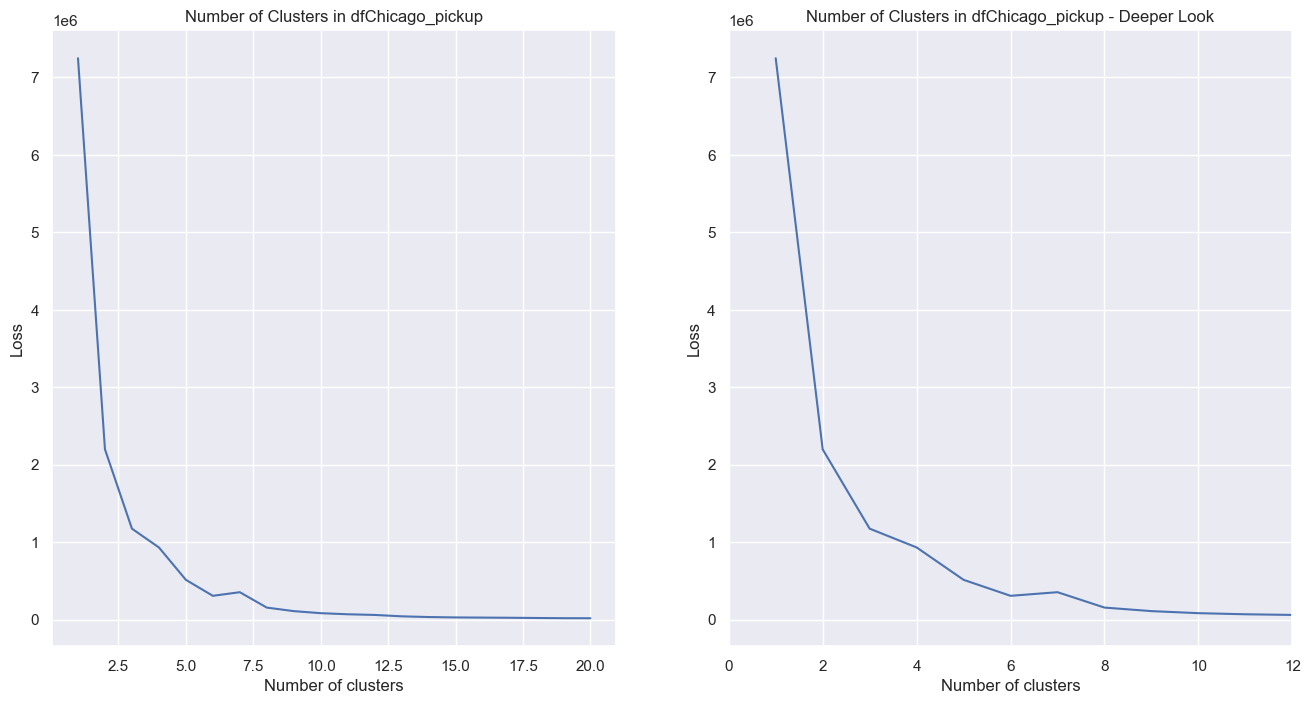

In [82]:
plot_best_fitting_number_of_clusters(dfChicago_clu_distance_to_city_center_pickup_scaled, "in dfChicago_pickup")

We again use the elbow method to declare the number of clusters. Looking at the plot above it seems that the elbow lies bewtween **two** and **four**, therefore we choose **three** as the numebr of clusters.

### 3.5.2 Computing Clusters with k-means++

In [83]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_distance_to_city_center_pickup_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_distance_to_city_center_pickup_scaled)

# creating a column for the calculated clusters

dfChicago_clu_distance_to_city_center_pickup.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_distance_to_city_center_pickup

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\275767884.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_distance_to_city_center_pickup.loc[:, 'cluster_number'] = Clusters


distance_to_city_center_pickup  cluster_number
0                              1.614272               0
1                              3.617721               2
2                              2.685629               2
3                              0.495382               0
4                              4.526819               2
...                                 ...             ...
7247312                        0.495382               0
7247313                        4.435183               2
7247314                        0.893287               0
7247315                        0.725199               0
7247316                        1.344327               0

[7247317 rows x 2 columns]

### 3.5.3 Analyzing & Labeling Clusters

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


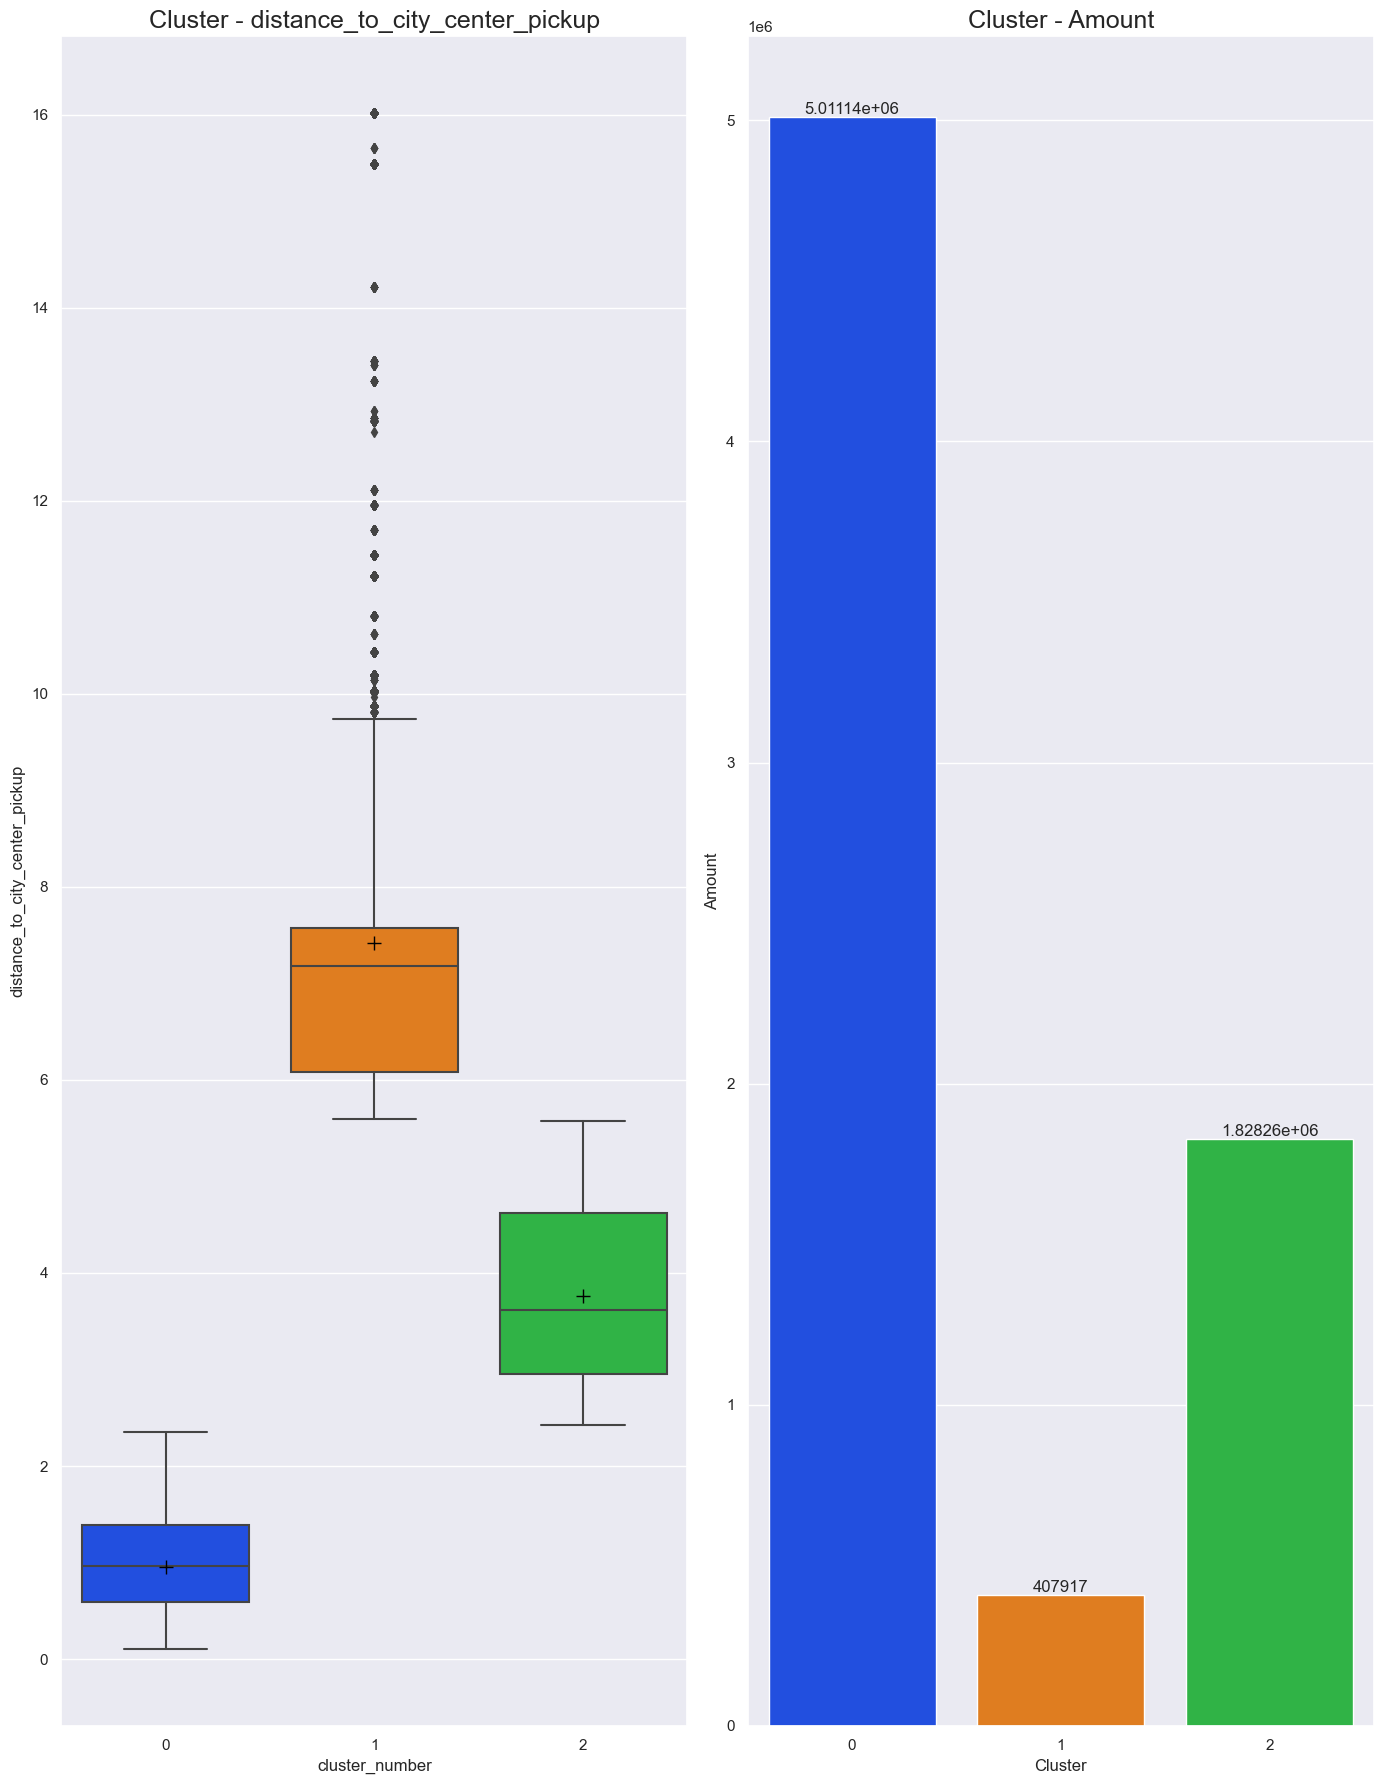

In [84]:
plot_information_about_clusters(dfChicago_clu_distance_to_city_center_pickup, ['distance_to_city_center_pickup'], 'cluster_number')

In [85]:
dfChicago_clu_distance_to_city_center_pickup_quantiles = get_quantiles_of_clusters(dfChicago_clu_distance_to_city_center_pickup, 3, 'cluster_number')
dfChicago_clu_distance_to_city_center_pickup_quantiles.sort_values(by=['distance_to_city_center_pickup'], ascending=False)

distance_to_city_center_pickup  Amount Trips in Cluster  Percentage
Cluster                                                                    
1                          6.08 - 7.57                 407917.0        5.63
2                          2.95 - 4.62                1828263.0       25.23
0                          0.59 - 1.39                5011137.0       69.14

In [86]:
label_names = {'0': "Close to City Center", 
               '1': "Medium Distance from the City Center",
               '2': "Far from City Center "
               }

# integrating our labeled clusters in the dataframe
dfChicago_clu_distance_to_city_center_pickup['Cluster_Label'] = dfChicago_clu_distance_to_city_center_pickup['cluster_number'].astype(str)
dfChicago_clu_distance_to_city_center_pickup = dfChicago_clu_distance_to_city_center_pickup.replace({"Cluster_Label": label_names})

dfChicago_clu_distance_to_city_center_pickup_index = dfChicago_clu_distance_to_city_center_pickup
dfChicago_clu_distance_to_city_center_pickup_index['Trip_Index'] = dfChicago_clu_distance_to_city_center_pickup_index.index
dfChicago_clu_distance_to_city_center_pickup_index

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\3786250274.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_distance_to_city_center_pickup['Cluster_Label'] = dfChicago_clu_distance_to_city_center_pickup['cluster_number'].astype(str)


distance_to_city_center_pickup  cluster_number  \
0                              1.614272               0   
1                              3.617721               2   
2                              2.685629               2   
3                              0.495382               0   
4                              4.526819               2   
...                                 ...             ...   
7247312                        0.495382               0   
7247313                        4.435183               2   
7247314                        0.893287               0   
7247315                        0.725199               0   
7247316                        1.344327               0   

                 Cluster_Label  Trip_Index  
0         Close to City Center           0  
1        Far from City Center            1  
2        Far from City Center            2  
3         Close to City Center           3  
4        Far from City Center            4  
...                        ...         ...  
7247312   Close to City Center     7247312  
7247313  Far from City Center      7247313  
7247314   Close to City Center     7247314  
7247315   Close to City Center     7247315  
7247316   Close to City Center     7247316  

[7247317 rows x 4 columns]

### 3.5.4 Plotting the Clustering Results

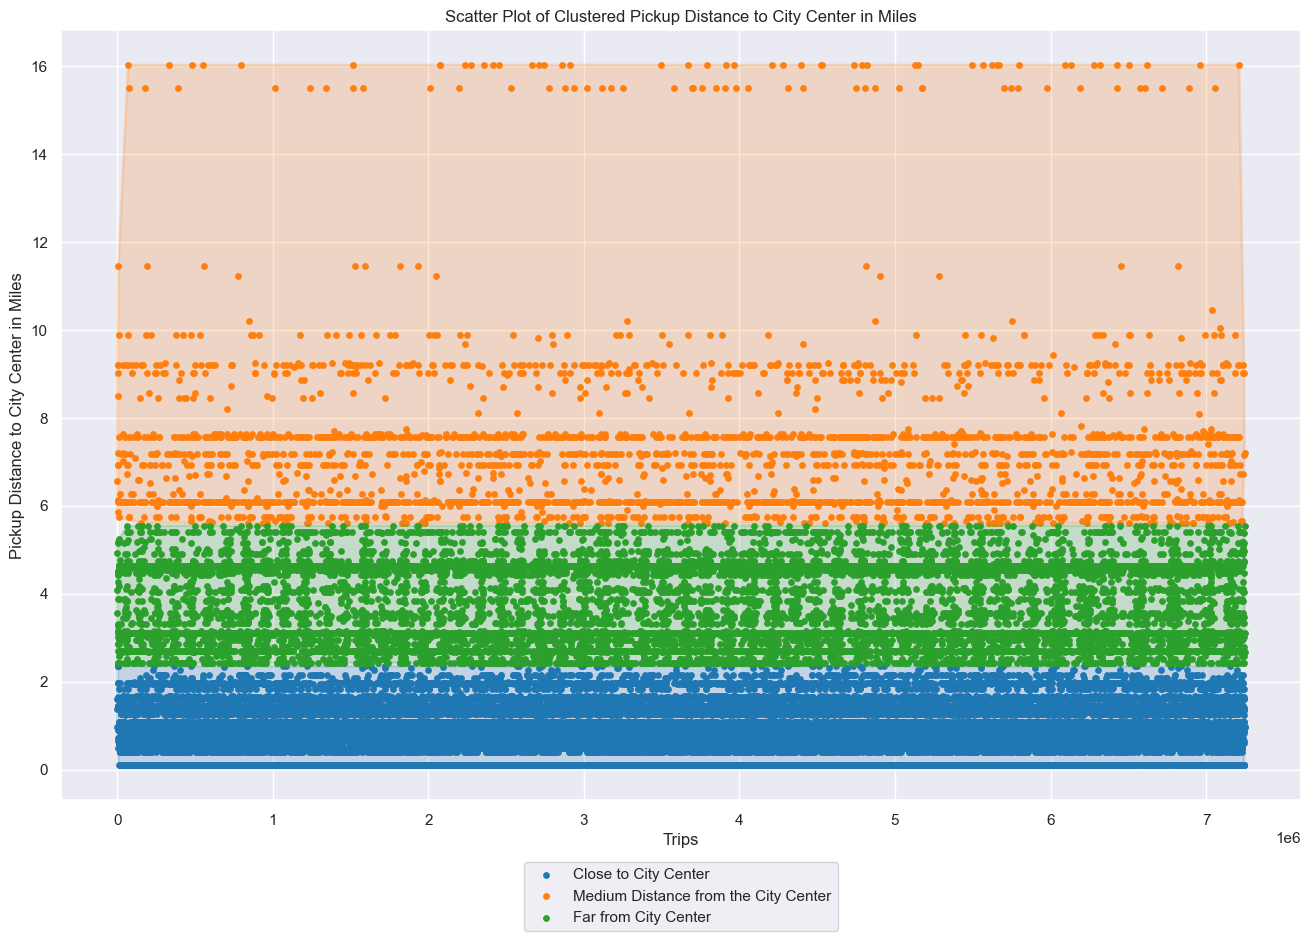

In [87]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_distance_to_city_center_pickup_index.sample(n=50_000), x_col='Trip_Index', y_col='distance_to_city_center_pickup', cluster_col='cluster_number',
                        label_col="Cluster_Label", size_tuple=(16, 10), dp_size=15, x_label='Trips', y_label="Pickup Distance to City Center in Miles", 
                        plot_title='Scatter Plot of Clustered Pickup Distance to City Center in Miles', leg_loc='lower center', anchor=(0.5, -0.18))

### 3.5.5 Displaying Results on a Map of Chicago

In [88]:
dfChicago_clu_distance_to_city_center_pickup_hex_ids = pd.DataFrame(dfChicago_clu_distance_to_city_center_pickup_index)

# Append the columns for the hexagon ids to clustered dataframe of distance to city center
dfChicago_clu_distance_to_city_center_pickup_hex_ids = pd.concat([dfChicago_clu_distance_to_city_center_pickup_hex_ids, 
                                                                dfChicago[['h3_hex_id_high_res', 'h3_hex_id_medium_res', 'h3_hex_id_low_res']]], axis=1)

dfChicago_clu_distance_to_city_center_pickup_hex_ids

distance_to_city_center_pickup  cluster_number  \
0                              1.614272               0   
1                              3.617721               2   
2                              2.685629               2   
3                              0.495382               0   
4                              4.526819               2   
...                                 ...             ...   
7247312                        0.495382               0   
7247313                        4.435183               2   
7247314                        0.893287               0   
7247315                        0.725199               0   
7247316                        1.344327               0   

                 Cluster_Label  Trip_Index h3_hex_id_high_res  \
0         Close to City Center           0    882664ca91fffff   
1        Far from City Center            1    882664c12bfffff   
2        Far from City Center            2    882664cac3fffff   
3         Close to City Center           3    882664c1adfffff   
4        Far from City Center            4    882664ca11fffff   
...                        ...         ...                ...   
7247312   Close to City Center     7247312    882664c1adfffff   
7247313  Far from City Center      7247313    882664c10dfffff   
7247314   Close to City Center     7247314    882664c1e1fffff   
7247315   Close to City Center     7247315    882664c1e3fffff   
7247316   Close to City Center     7247316    882664c1ebfffff   

        h3_hex_id_medium_res h3_hex_id_low_res  
0            872664ca9ffffff   862664cafffffff  
1            872664c12ffffff   862664c17ffffff  
2            872664cacffffff   862664cafffffff  
3            872664c1affffff   862664c1fffffff  
4            872664ca1ffffff   862664ca7ffffff  
...                      ...               ...  
7247312      872664c1affffff   862664c1fffffff  
7247313      872664c10ffffff   862664c17ffffff  
7247314      872664c1effffff   862664c1fffffff  
7247315      872664c1effffff   862664c1fffffff  
7247316      872664c1effffff   862664c1fffffff  

[7247317 rows x 7 columns]

In [89]:
# create lists of hex ids for each cluster
hex_ids_for_cluster_0 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 0, 'h3_hex_id_high_res')
hex_ids_for_cluster_1 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 1, 'h3_hex_id_high_res')
hex_ids_for_cluster_2 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 2, 'h3_hex_id_high_res')

# Generate Map with high resolution hexagons for pickup distance to city center clusters
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_2, color='#2ca02c') 
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_1, color='#ff7f0e', folium_map=m_hex_high_pickup_distance_city_center) 
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_0, color='#1f77b4', folium_map=m_hex_high_pickup_distance_city_center)
display(m_hex_high_pickup_distance_city_center)

<hr style="border: 1px solid #8888;">

## 3.6 Sixth Cluster Analysis: `distance_to_city_center_dropoff`

In [90]:
# Feature selection
dfChicago_clu_distance_to_city_center_dropoff = dfChicago[['distance_to_city_center_dropoff']]
dfChicago_clu_distance_to_city_center_dropoff

distance_to_city_center_dropoff
0                               1.387700
1                               3.548918
2                               2.685629
3                               0.587129
4                               4.526819
...                                  ...
7247312                         0.495382
7247313                         7.088074
7247314                         1.959038
7247315                         1.609951
7247316                         2.141079

[7247317 rows x 1 columns]

#### Scaling the Data

In [91]:
# Scaling the data
dfChicago_clu_distance_to_city_center_dropoff_scaled = scaling_data(dfChicago_clu_distance_to_city_center_dropoff)

### 3.6.1 Validation of Number of Clusters

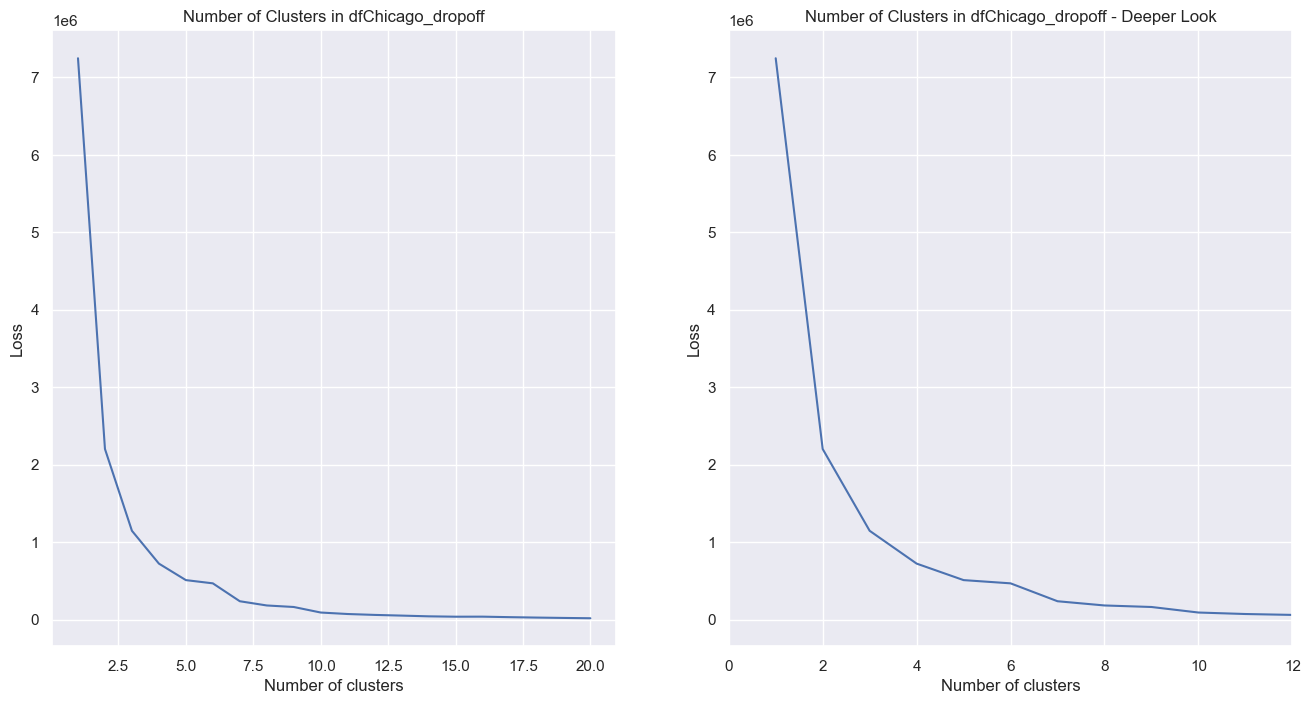

In [92]:
plot_best_fitting_number_of_clusters(dfChicago_clu_distance_to_city_center_dropoff_scaled, "in dfChicago_dropoff")

We again use the elbow method to declare the number of clusters. Looking at the plot above it seems that the elbow lies bewtween **two** and **four**, therefore we choose **three** as the numebr of clusters.

### 3.6.2 Computing Clusters with k-means++

In [93]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_distance_to_city_center_dropoff_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_distance_to_city_center_dropoff_scaled)

# creating a column for the calculated clusters
dfChicago_clu_distance_to_city_center_dropoff.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_distance_to_city_center_dropoff

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\200745104.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_distance_to_city_center_dropoff.loc[:, 'cluster_number'] = Clusters


distance_to_city_center_dropoff  cluster_number
0                               1.387700               1
1                               3.548918               0
2                               2.685629               0
3                               0.587129               1
4                               4.526819               0
...                                  ...             ...
7247312                         0.495382               1
7247313                         7.088074               2
7247314                         1.959038               1
7247315                         1.609951               1
7247316                         2.141079               1

[7247317 rows x 2 columns]

### 3.6.3 Analyzing & Labeling Clusters

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


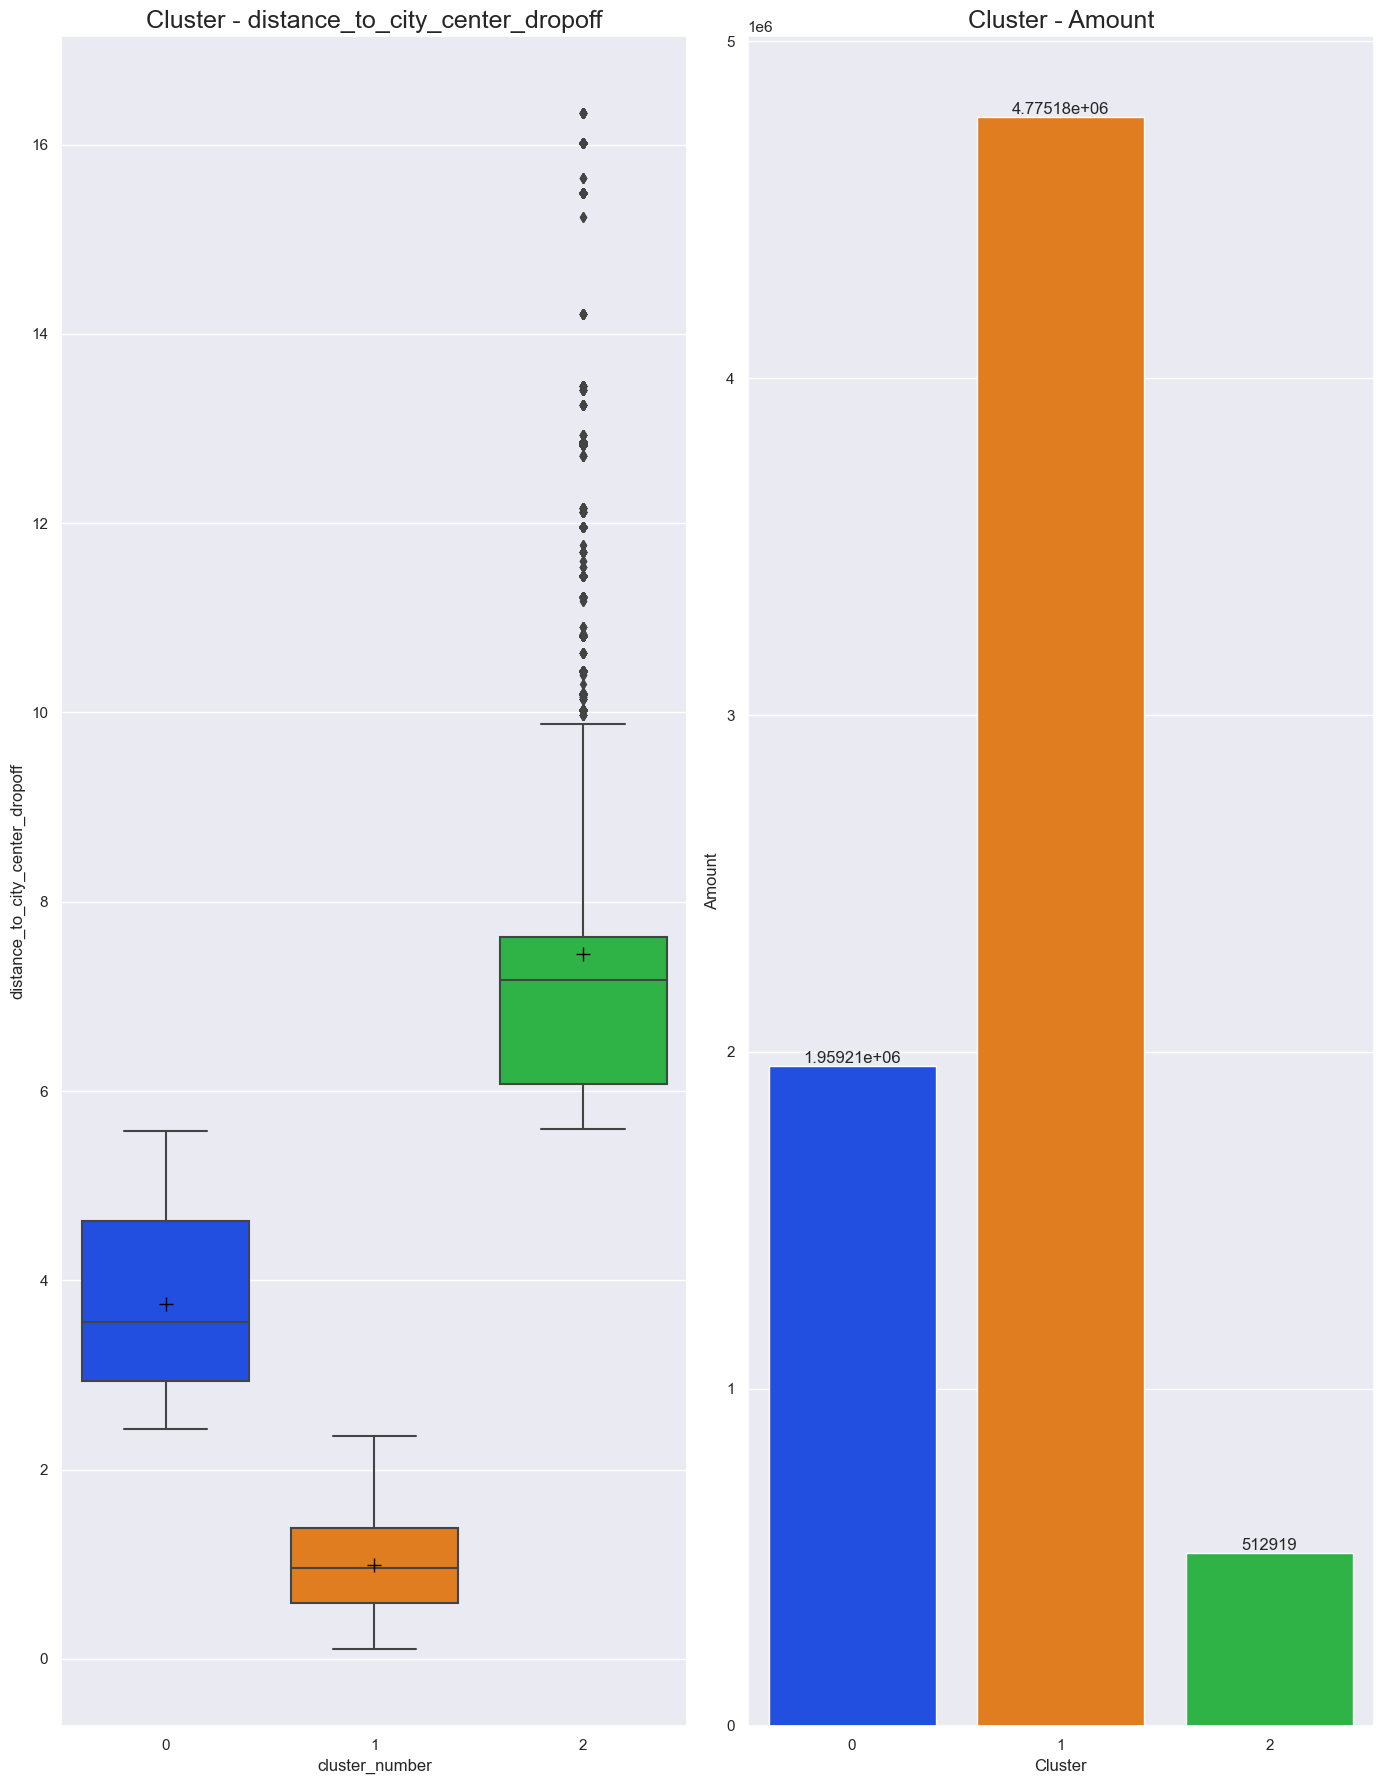

In [94]:
plot_information_about_clusters(dfChicago_clu_distance_to_city_center_dropoff, ['distance_to_city_center_dropoff'], 'cluster_number')

In [95]:
dfChicago_clu_distance_to_city_center_dropoff_quantiles = get_quantiles_of_clusters(dfChicago_clu_distance_to_city_center_dropoff, 3, 'cluster_number')
dfChicago_clu_distance_to_city_center_dropoff_quantiles.sort_values(by=['distance_to_city_center_dropoff'], ascending=False)

distance_to_city_center_dropoff  Amount Trips in Cluster  Percentage
Cluster                                                                     
2                           6.08 - 7.63                 512919.0        7.08
0                           2.94 - 4.62                1959214.0       27.03
1                           0.59 - 1.39                4775184.0       65.89

In [96]:
label_names = {'0': "Medium Distance from the City Center", 
               '1': "Close to City Center",
               '2': "Far from City Center "
               }

# integrating our labeled clusters in the dataframe
dfChicago_clu_distance_to_city_center_dropoff['Cluster_Label'] = dfChicago_clu_distance_to_city_center_dropoff['cluster_number'].astype(str)
dfChicago_clu_distance_to_city_center_dropoff = dfChicago_clu_distance_to_city_center_dropoff.replace({"Cluster_Label": label_names})

dfChicago_clu_distance_to_city_center_dropoff_index = dfChicago_clu_distance_to_city_center_dropoff
dfChicago_clu_distance_to_city_center_dropoff_index['Trip_Index'] = dfChicago_clu_distance_to_city_center_dropoff_index.index
dfChicago_clu_distance_to_city_center_dropoff_index

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\4125057298.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_distance_to_city_center_dropoff['Cluster_Label'] = dfChicago_clu_distance_to_city_center_dropoff['cluster_number'].astype(str)


distance_to_city_center_dropoff  cluster_number  \
0                               1.387700               1   
1                               3.548918               0   
2                               2.685629               0   
3                               0.587129               1   
4                               4.526819               0   
...                                  ...             ...   
7247312                         0.495382               1   
7247313                         7.088074               2   
7247314                         1.959038               1   
7247315                         1.609951               1   
7247316                         2.141079               1   

                                Cluster_Label  Trip_Index  
0                        Close to City Center           0  
1        Medium Distance from the City Center           1  
2        Medium Distance from the City Center           2  
3                        Close to City Center           3  
4        Medium Distance from the City Center           4  
...                                       ...         ...  
7247312                  Close to City Center     7247312  
7247313                 Far from City Center      7247313  
7247314                  Close to City Center     7247314  
7247315                  Close to City Center     7247315  
7247316                  Close to City Center     7247316  

[7247317 rows x 4 columns]

### 3.6.4 Plotting the Clustering Results

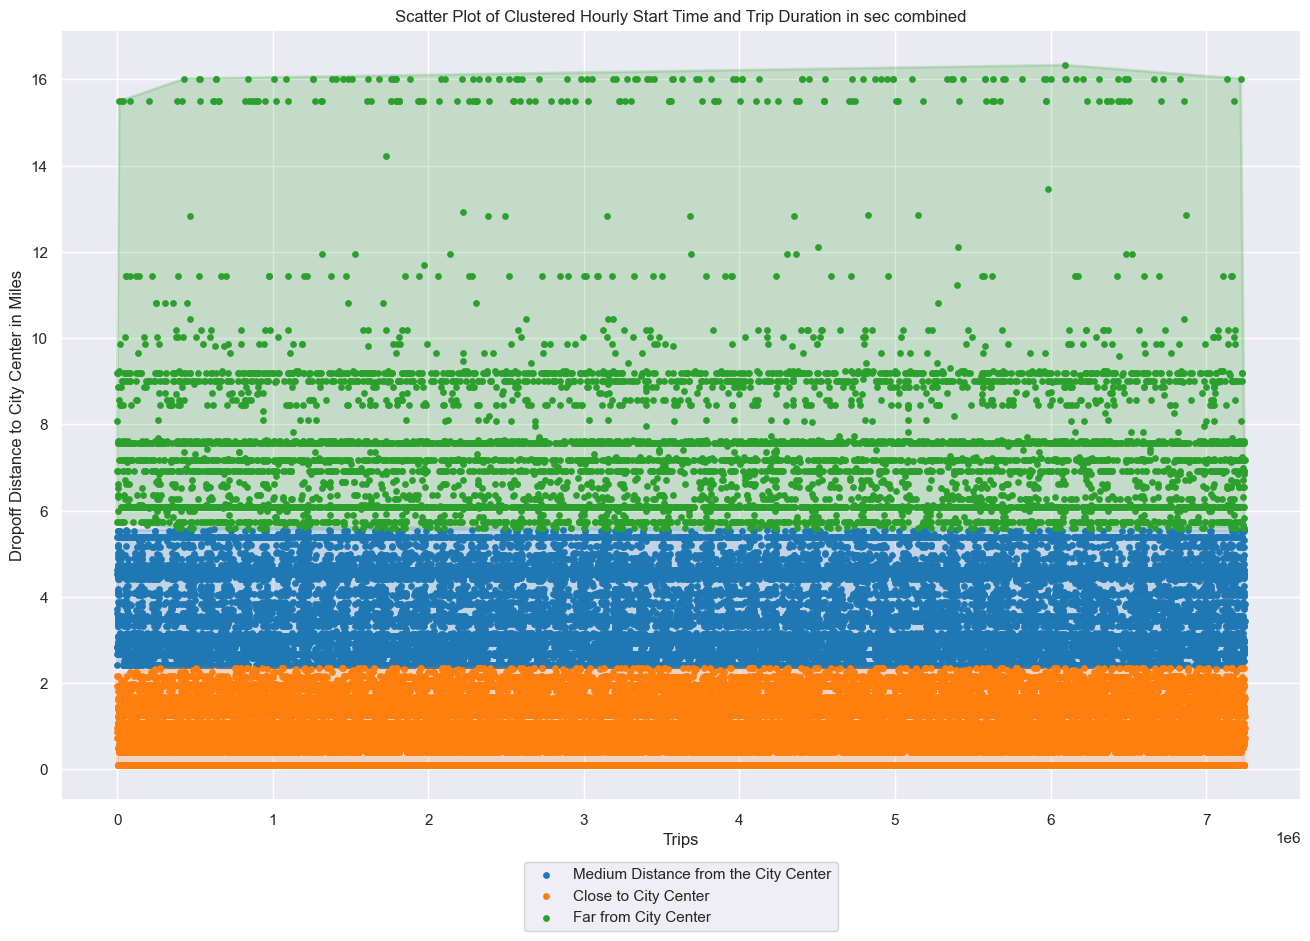

In [97]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_distance_to_city_center_dropoff_index.sample(n=100_000), x_col='Trip_Index', y_col='distance_to_city_center_dropoff', cluster_col='cluster_number', 
                        label_col="Cluster_Label", size_tuple=(16, 10), dp_size=15, x_label='Trips', y_label="Dropoff Distance to City Center in Miles", 
                        plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Duration in sec combined', leg_loc='lower center', anchor=(0.5, -0.18))

### 3.6.5 Displaying Results on a Map of Chicago

In [98]:
dfChicago_clu_distance_to_city_center_dropoff_hex_ids = pd.DataFrame(dfChicago_clu_distance_to_city_center_dropoff_index)

# Append the columns for the hexagon ids to clustered dataframe of distance to city center
dfChicago_clu_distance_to_city_center_dropoff_hex_ids = pd.concat([dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 
                                                                dfChicago[['h3_hex_id_high_res', 'h3_hex_id_medium_res', 'h3_hex_id_low_res']]], axis=1)

dfChicago_clu_distance_to_city_center_dropoff_hex_ids

distance_to_city_center_dropoff  cluster_number  \
0                               1.387700               1   
1                               3.548918               0   
2                               2.685629               0   
3                               0.587129               1   
4                               4.526819               0   
...                                  ...             ...   
7247312                         0.495382               1   
7247313                         7.088074               2   
7247314                         1.959038               1   
7247315                         1.609951               1   
7247316                         2.141079               1   

                                Cluster_Label  Trip_Index h3_hex_id_high_res  \
0                        Close to City Center           0    882664ca91fffff   
1        Medium Distance from the City Center           1    882664c12bfffff   
2        Medium Distance from the City Center           2    882664cac3fffff   
3                        Close to City Center           3    882664c1adfffff   
4        Medium Distance from the City Center           4    882664ca11fffff   
...                                       ...         ...                ...   
7247312                  Close to City Center     7247312    882664c1adfffff   
7247313                 Far from City Center      7247313    882664c10dfffff   
7247314                  Close to City Center     7247314    882664c1e1fffff   
7247315                  Close to City Center     7247315    882664c1e3fffff   
7247316                  Close to City Center     7247316    882664c1ebfffff   

        h3_hex_id_medium_res h3_hex_id_low_res  
0            872664ca9ffffff   862664cafffffff  
1            872664c12ffffff   862664c17ffffff  
2            872664cacffffff   862664cafffffff  
3            872664c1affffff   862664c1fffffff  
4            872664ca1ffffff   862664ca7ffffff  
...                      ...               ...  
7247312      872664c1affffff   862664c1fffffff  
7247313      872664c10ffffff   862664c17ffffff  
7247314      872664c1effffff   862664c1fffffff  
7247315      872664c1effffff   862664c1fffffff  
7247316      872664c1effffff   862664c1fffffff  

[7247317 rows x 7 columns]

In [99]:
# create lists of hex ids for each cluster
dropoff_hex_ids_for_cluster_0 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 0, 'h3_hex_id_high_res')
dropoff_hex_ids_for_cluster_1 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 1, 'h3_hex_id_high_res')
dropoff_hex_ids_for_cluster_2 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 2, 'h3_hex_id_high_res')

# Generate Map with high resolution hexagons for pickup distance to city center clusters
m_hex_high_dropoff_distance_city_center = visualize_hexagons(dropoff_hex_ids_for_cluster_2, color='#2ca02c') 
m_hex_high_dropoff_distance_city_center = visualize_hexagons(dropoff_hex_ids_for_cluster_0, color='#ff7f0e', folium_map=m_hex_high_dropoff_distance_city_center) 
m_hex_high_dropoff_distance_city_center = visualize_hexagons(dropoff_hex_ids_for_cluster_1, color='#1f77b4', folium_map=m_hex_high_dropoff_distance_city_center)
display(m_hex_high_pickup_distance_city_center)

<hr style="border: 1px solid #8888;">

##  3.7 Seventh Cluster Analysis: `distance_to_city_center_dropoff`, `distance_to_city_center_pickup`, `Trip_Minutes` and `Trip_Miles`

In [100]:
# Feature selection
dfChicago_clu_location = dfChicago[['distance_to_city_center_pickup','distance_to_city_center_dropoff',"Trip_Miles",'Trip_Minutes']]
dfChicago_clu_location

distance_to_city_center_pickup  distance_to_city_center_dropoff  \
0                              1.614272                         1.387700   
1                              3.617721                         3.548918   
2                              2.685629                         2.685629   
3                              0.495382                         0.587129   
4                              4.526819                         4.526819   
...                                 ...                              ...   
7247312                        0.495382                         0.495382   
7247313                        4.435183                         7.088074   
7247314                        0.893287                         1.959038   
7247315                        0.725199                         1.609951   
7247316                        1.344327                         2.141079   

         Trip_Miles  Trip_Minutes  
0               2.7          15.0  
1               0.4           4.0  
2               1.0           3.0  
3               0.3           4.0  
4               0.8           8.0  
...             ...           ...  
7247312         0.5           3.0  
7247313         5.1          19.0  
7247314         1.4           9.0  
7247315         2.0          12.0  
7247316         3.5          11.0  

[7247317 rows x 4 columns]

#### Scaling the data:

In [101]:
# Scaling the data
dfChicago_clu_location_scaled = scaling_data(dfChicago_clu_location)

### 3.7.1 Validation of Number of Clusters

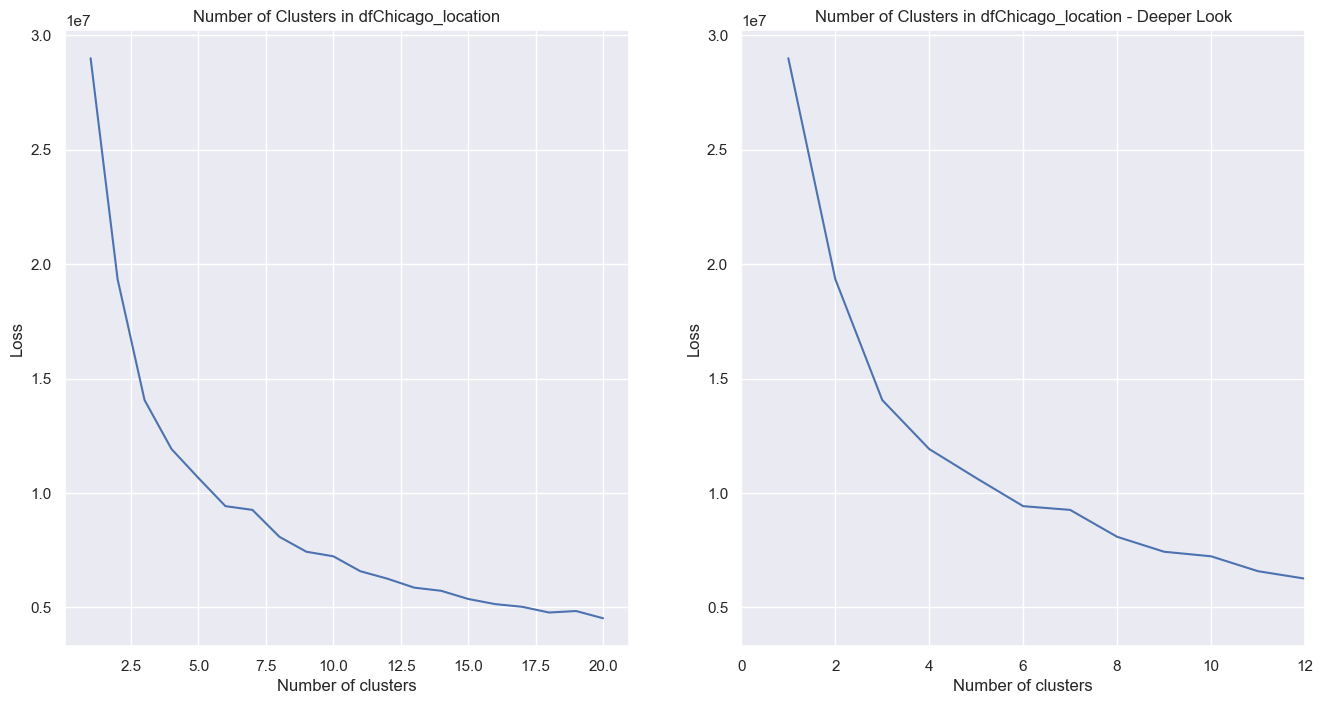

In [102]:
plot_best_fitting_number_of_clusters(dfChicago_clu_location_scaled, "in dfChicago_location")

We again use the elbow method to declare the number of clusters. Looking at the plot above it seems that the elbow lies bewtween **three** and **five**, therefore we choose **four** as the numebr of clusters.

### 3.7.2 Computing Clusters with k-means++

In [103]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=4,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_location_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_location_scaled)

# creating a column for the calculated clusters
dfChicago_clu_location.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_location

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\3494043648.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_location.loc[:, 'cluster_number'] = Clusters


distance_to_city_center_pickup  distance_to_city_center_dropoff  \
0                              1.614272                         1.387700   
1                              3.617721                         3.548918   
2                              2.685629                         2.685629   
3                              0.495382                         0.587129   
4                              4.526819                         4.526819   
...                                 ...                              ...   
7247312                        0.495382                         0.495382   
7247313                        4.435183                         7.088074   
7247314                        0.893287                         1.959038   
7247315                        0.725199                         1.609951   
7247316                        1.344327                         2.141079   

         Trip_Miles  Trip_Minutes  cluster_number  
0               2.7          15.0               3  
1               0.4           4.0               0  
2               1.0           3.0               2  
3               0.3           4.0               2  
4               0.8           8.0               0  
...             ...           ...             ...  
7247312         0.5           3.0               2  
7247313         5.1          19.0               1  
7247314         1.4           9.0               3  
7247315         2.0          12.0               3  
7247316         3.5          11.0               3  

[7247317 rows x 5 columns]

### 3.7.3 Analyzing & Labeling clusters

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


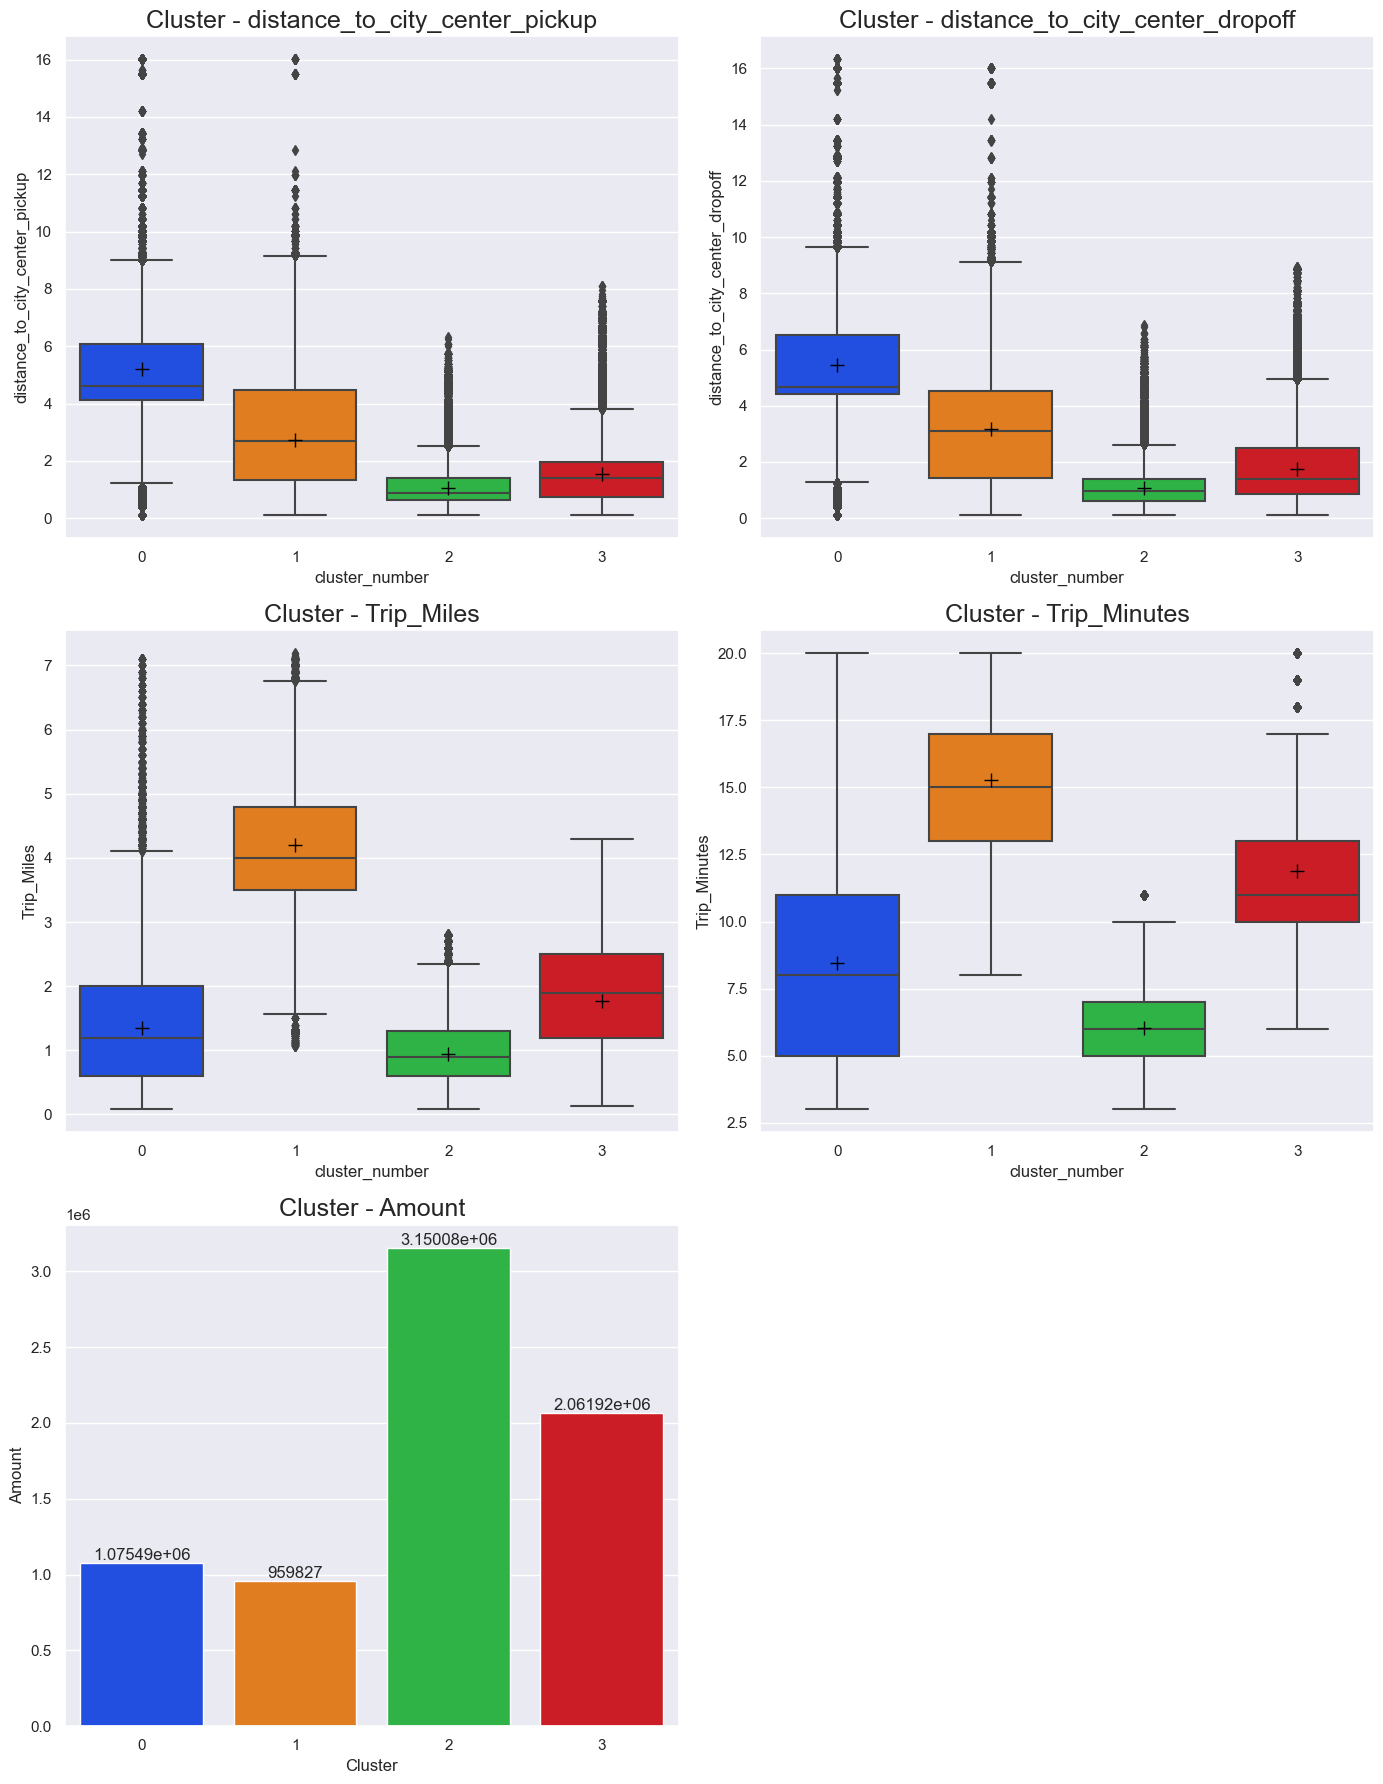

In [104]:
plot_information_about_clusters(dfChicago_clu_location, ['distance_to_city_center_pickup','distance_to_city_center_dropoff',"Trip_Miles",'Trip_Minutes'], 'cluster_number')

In [108]:
dfChicago_clu_location_quantiles = get_quantiles_of_clusters(dfChicago_clu_location, 4, 'cluster_number')
dfChicago_clu_location_quantiles.sort_values(by=['distance_to_city_center_pickup', 'Trip_Miles'], ascending=False)

distance_to_city_center_pickup distance_to_city_center_dropoff  \
Cluster                                                                  
0                          4.13 - 6.08                     4.42 - 6.51   
1                          1.34 - 4.47                     1.44 - 4.53   
3                          0.73 - 1.96                     0.87 - 2.51   
2                          0.64 - 1.39                      0.59 - 1.4   

        Trip_Miles Trip_Minutes  Amount Trips in Cluster  Percentage  
Cluster                                                               
0        0.6 - 2.0   5.0 - 11.0                1075488.0       14.84  
1        3.5 - 4.8  13.0 - 17.0                 959827.0       13.24  
3        1.2 - 2.5  10.0 - 13.0                2061925.0       28.45  
2        0.6 - 1.3    5.0 - 7.0                3150077.0       43.47

In [109]:
label_names = {'0': "Far from City Center - Short Trip Customers", 
               '1': "Far from City Center - Long Trip Customers",
               '2': "Close to City Center - Short Trip Customers",
               '3': "Close to City Center - Long Trip Customers",
               }

# integrating our labeled clusters in the dataframe
dfChicago_clu_location['Cluster_Label'] = dfChicago_clu_location['cluster_number'].astype(str)
dfChicago_clu_location = dfChicago_clu_location.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_19428\2354647747.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_location['Cluster_Label'] = dfChicago_clu_location['cluster_number'].astype(str)


### 3.7.4 Plotting the Clustering Results

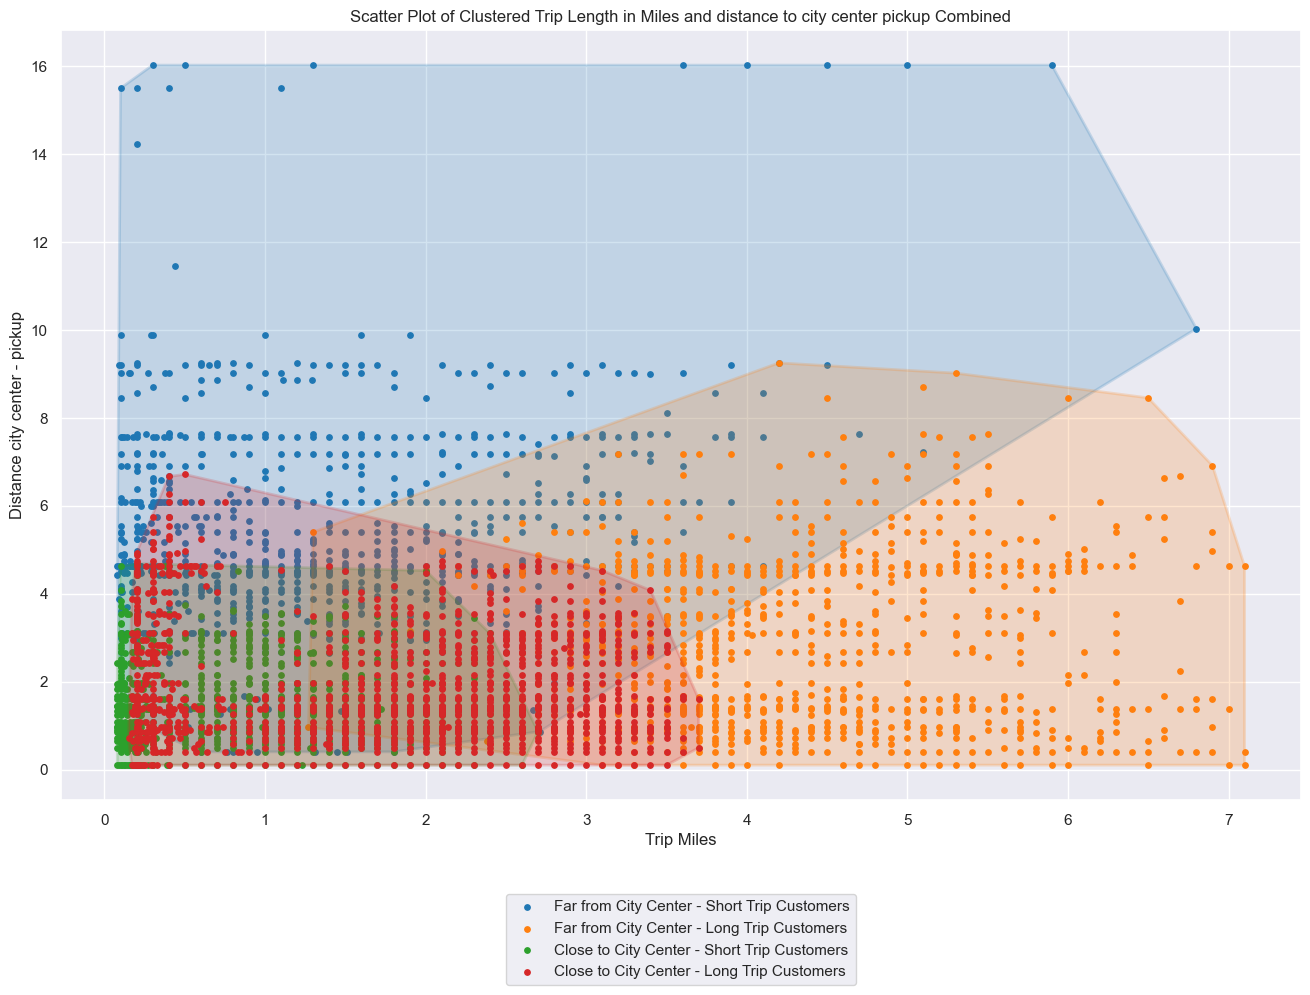

In [112]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_location.sample(n=10_000), x_col='Trip_Miles', y_col='distance_to_city_center_pickup', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Miles', y_label="Distance city center - pickup", plot_title='Scatter Plot of Clustered Trip Length in Miles and distance to city center pickup Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

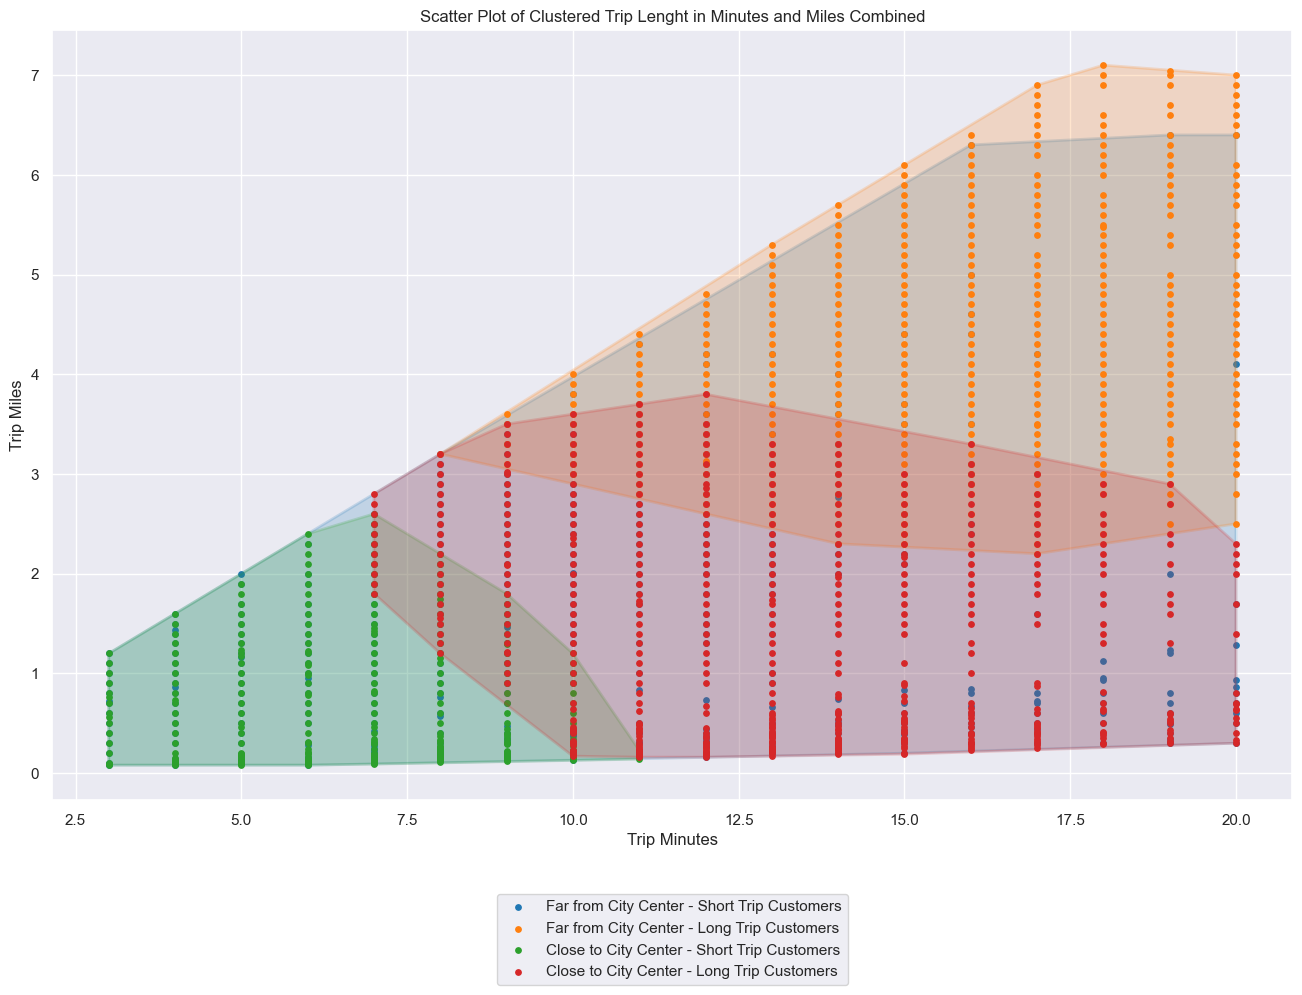

In [113]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_location.sample(n=10_000), x_col='Trip_Minutes', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Minutes', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Trip Lenght in Minutes and Miles Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

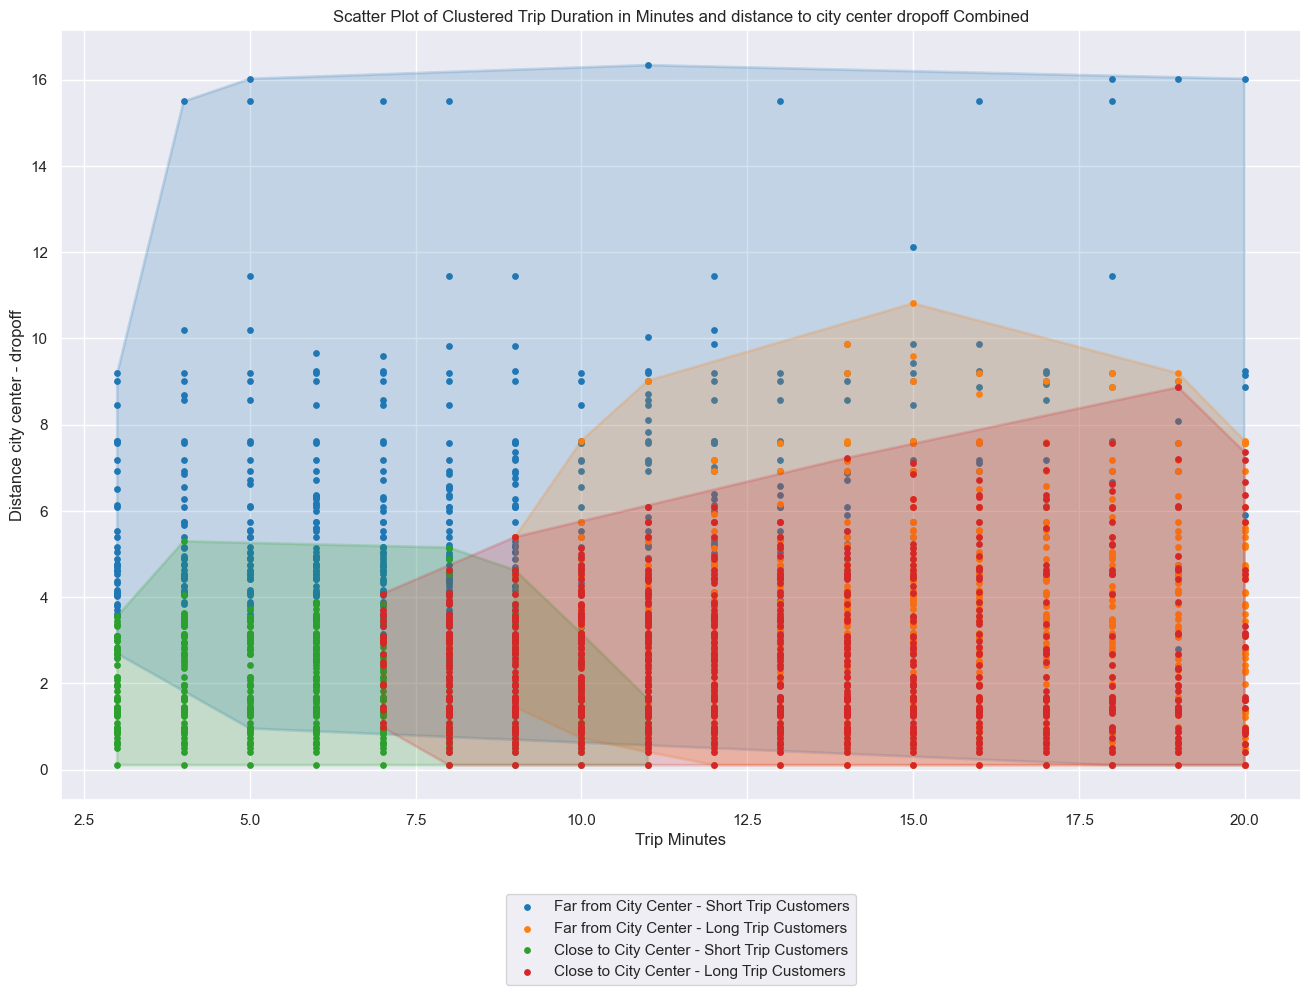

In [114]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_location.sample(n=10_000), x_col='Trip_Minutes', y_col='distance_to_city_center_dropoff', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Minutes', y_label="Distance city center - dropoff", plot_title='Scatter Plot of Clustered Trip Duration in Minutes and distance to city center dropoff Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

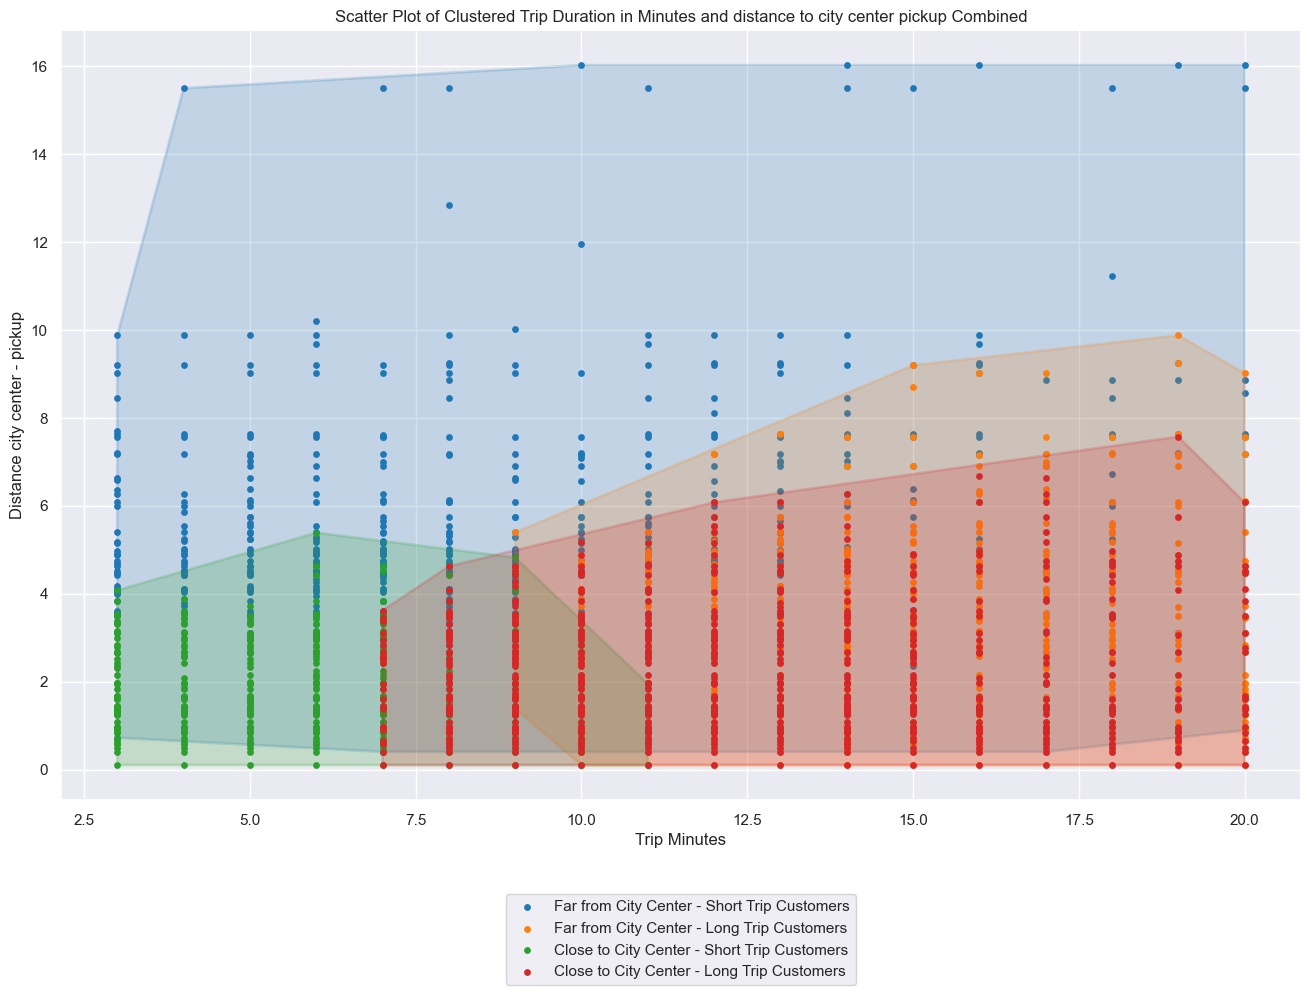

In [115]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_location.sample(n=10_000), x_col='Trip_Minutes', y_col='distance_to_city_center_pickup', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Minutes', y_label="Distance city center - pickup", plot_title='Scatter Plot of Clustered Trip Duration in Minutes and distance to city center pickup Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


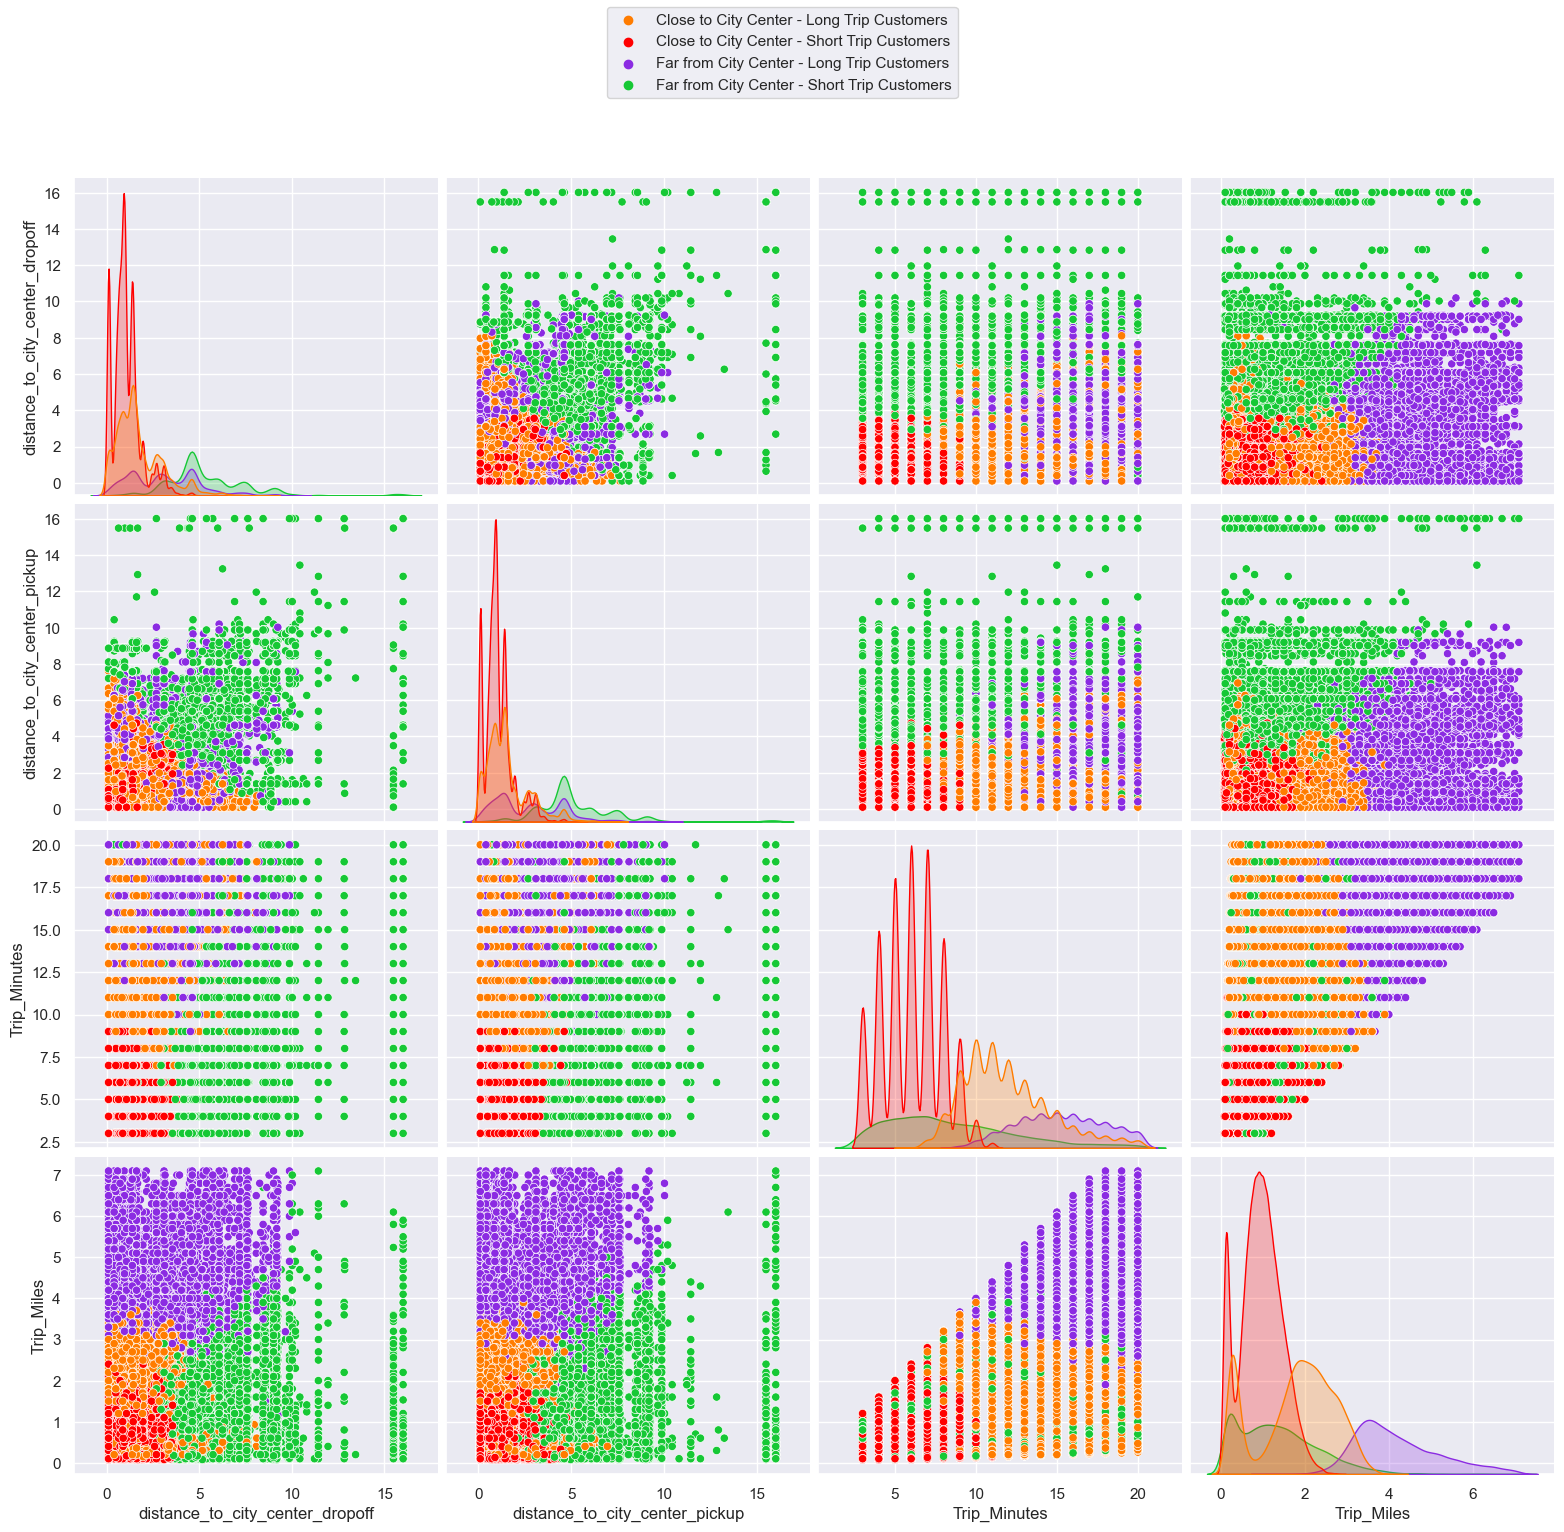

In [117]:
colors = {
          "Medium Distance from the City Center - Medium Trip Customers" : '#023EFF', 
            "Close to City Center - Long Trip Customers":'#FF7C00',
            "Far from City Center - Short Trip Customers": '#16C835',
             "Close to City Center - Short Trip Customers": '#FF0000',
          "Far from City Center - Long Trip Customers": '#8B2BE2'}


g = sns.pairplot(data=dfChicago_clu_location[['distance_to_city_center_dropoff','distance_to_city_center_pickup', 'Trip_Minutes' ,'Trip_Miles', 'Cluster_Label']].sample(100_000),
             hue = 'Cluster_Label', palette=colors, height=4, aspect=1)

#styling the output
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.subplots_adjust(top=0.89, bottom=0.08)